# Capstone 2, Notebook 3
### Final Model Creation

This notebook will cover the building of a machine learning pipeline to cover how the final product was tested and trained. 

In the prior segments the data was compiled and examined to verify the shape and importance of the features on daily fantasy points. In the second segment, we created many moving averages to test out the theory that stock forecasting techniques could be effectively applied the forecasting of a players' performance. While that did have some validity, it was not significant enough to be the only method.

This segment is to document the creation of a number of new models from the compiled data. The pipeline utilized three models: Stochastic Gradient Descent, random forests, and xgboost. 

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn import preprocessing
from sklearn import utils
import xgboost 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pactools import simulate_pac
from pactools.grid_search import ExtractDriver, AddDriverDelay
from pactools.grid_search import DARSklearn, MultipleArray
from pactools.grid_search import GridSearchCVProgressBar

In [2]:
base_data = pd.read_csv("cleanedPlayerStats.csv.gz", compression='gzip')
print(base_data.shape)

(441586, 490)


In [3]:
pd.set_option('display.max_columns', 800)
base_data.head()

,player,game_order,game_id,index,game_date,season_comp,Team_comp,Opponent_comp,is_home_comp,TOI_comp,G_comp,A1_comp,A2_comp,Points_comp,iSF_comp,iFF_comp,iCF_comp,ixG_comp,iBLK_comp,iHF,iHA,GIVE,TAKE,iPENT2_comp,iPEND2_comp,iPENT5_comp,iPEND5_comp,FOW_comp,FOL_comp,OZS_comp,NZS_comp,DZS_comp,t_TOI_comp,TOI_ev,G_ev,A1_ev,A2_ev,Points_ev,iSF_ev,iFF_ev,iCF_ev,ixG_ev,iBLK_ev,GIVE_o,GIVE_n,GIVE_d,TAKE_o,TAKE_n,TAKE_d,iHF_o,iHF_n,iHF_d,iHA_o,iHA_n,iHA_d,FOW_ev,FOL_ev,OZS_ev,NZS_ev,DZS_ev,iPENT2_ev,iPEND2_ev,iPENT5_ev,iPEND5_ev,onGF,onGA,onSF,onSA,onFF,onFA,onCF,onCA,onxGF,onxGA,onGF_state,onGA_state,onSF_state,onSA_state,onFF_state,onFA_state,onCF_state,onCA_state,onxGF_state,onxGA_state,t_TOI_ev,t_GF,t_GA,t_SF,t_SA,t_FF,t_FA,t_CF,t_CA,t_xGF,t_xGA,t_GF_state,t_GA_state,t_SF_state,t_SA_state,t_FF_state,t_FA_state,t_CF_state,t_CA_state,t_xGF_state,t_xGA_state,TOI,G,A1,A2,Points,iSF,iFF,iCF,ixG,GIVE_o_pp,GIVE_n_pp,GIVE_d_pp,TAKE_o_pp,TAKE_n_pp,TAKE_d_pp,iHF_o_pp,iHF_n_pp,iHF_d_pp,iHA_o_pp,iHA_n_pp,iHA_d_pp,FOW,FOL,OZS,NZS,DZS,iPENT2,iPEND2,iPENT5,iPEND5,onGF_pp,onGA_pp,onSF_pp,onSA_pp,onFF_pp,onFA_pp,onCF_pp,onCA_pp,onxGF_pp,onxGA_pp,onGF_state_pp,onGA_state_pp,onSF_state_pp,onSA_state_pp,onFF_state_pp,onFA_state_pp,onCF_state_pp,onCA_state_pp,onxGF_state_pp,onxGA_state_pp,t_TOI,t_GF_pp,t_GA_pp,t_SF_pp,t_SA_pp,t_FF_pp,t_FA_pp,t_CF_pp,t_CA_pp,t_xGF_pp,t_xGA_pp,t_GF_state_pp,t_GA_state_pp,t_SF_state_pp,t_SA_state_pp,t_FF_state_pp,t_FA_state_pp,t_CF_state_pp,t_CA_state_pp,t_xGF_state_pp,t_xGA_state_pp,TOI_sh,G_sh,A1_sh,A2_sh,Points_sh,iSF_sh,iFF_sh,iCF_sh,ixG_sh,iBLK,GIVE_o_sh,GIVE_n_sh,GIVE_d_sh,TAKE_o_sh,TAKE_n_sh,TAKE_d_sh,iHF_o_sh,iHF_n_sh,iHF_d_sh,iHA_o_sh,iHA_n_sh,iHA_d_sh,FOW_sh,FOL_sh,OZS_sh,NZS_sh,DZS_sh,iPENT2_sh,iPEND2_sh,iPENT5_sh,iPEND5_sh,onGF_sh,onGA_sh,onSF_sh,onSA_sh,onFF_sh,onFA_sh,onCF_sh,onCA_sh,onxGF_sh,onxGA_sh,onGF_state_sh,onGA_state_sh,onSF_state_sh,onSA_state_sh,onFF_state_sh,onFA_state_sh,onCF_state_sh,onCA_state_sh,onxGF_state_sh,onxGA_state_sh,t_TOI_sh,t_GF_sh,t_GA_sh,t_SF_sh,t_SA_sh,t_FF_sh,t_FA_sh,t_CF_sh,t_CA_sh,t_xGF_sh,t_xGA_sh,t_GF_state_sh,t_GA_state_sh,t_SF_state_sh,t_SA_state_sh,t_FF_state_sh,t_FA_state_sh,t_CF_state_sh,t_CA_state_sh,t_xGF_state_sh,t_xGA_state_sh,hat_trick,dk_points,skater_toi_percentage,skater_pptoi_percentage,skater_shtoi_percentage,points_per_60,iFF_per_60,ixG_per_60,position,position_type,firstname,lastname,game_id_avg_lt,TOI_comp_avg_lt,G_comp_avg_lt,Points_comp_avg_lt,iSF_comp_avg_lt,iFF_comp_avg_lt,iCF_comp_avg_lt,ixG_comp_avg_lt,iBLK_comp_avg_lt,iHF_avg_lt,OZS_comp_avg_lt,TOI_ev_avg_lt,G_ev_avg_lt,Points_ev_avg_lt,iSF_ev_avg_lt,iFF_ev_avg_lt,iCF_ev_avg_lt,ixG_ev_avg_lt,iBLK_ev_avg_lt,onGF_avg_lt,onFF_avg_lt,onCF_avg_lt,onxGF_avg_lt,onFA_state_avg_lt,TOI_avg_lt,G_avg_lt,Points_avg_lt,iSF_avg_lt,iFF_avg_lt,iCF_avg_lt,ixG_avg_lt,onGF_pp_avg_lt,onSF_pp_avg_lt,onFF_pp_avg_lt,onCF_pp_avg_lt,onxGF_pp_avg_lt,TOI_sh_avg_lt,G_sh_avg_lt,Points_sh_avg_lt,iSF_sh_avg_lt,iFF_sh_avg_lt,iCF_sh_avg_lt,ixG_sh_avg_lt,onGF_sh_avg_lt,onSF_sh_avg_lt,onFF_sh_avg_lt,onCF_sh_avg_lt,onxGF_sh_avg_lt,onxGA_sh_avg_lt,hat_trick_avg_lt,dk_points_avg_lt,skater_toi_percentage_avg_lt,skater_pptoi_percentage_avg_lt,skater_shtoi_percentage_avg_lt,points_per_60_avg_lt,iFF_per_60_avg_lt,ixG_per_60_avg_lt,game_id_avg_lf,TOI_comp_avg_lf,G_comp_avg_lf,Points_comp_avg_lf,iSF_comp_avg_lf,iFF_comp_avg_lf,iCF_comp_avg_lf,ixG_comp_avg_lf,iBLK_comp_avg_lf,iHF_avg_lf,OZS_comp_avg_lf,TOI_ev_avg_lf,G_ev_avg_lf,Points_ev_avg_lf,iSF_ev_avg_lf,iFF_ev_avg_lf,iCF_ev_avg_lf,ixG_ev_avg_lf,iBLK_ev_avg_lf,onGF_avg_lf,onFF_avg_lf,onCF_avg_lf,onxGF_avg_lf,onFA_state_avg_lf,TOI_avg_lf,G_avg_lf,Points_avg_lf,iSF_avg_lf,iFF_avg_lf,iCF_avg_lf,ixG_avg_lf,onGF_pp_avg_lf,onSF_pp_avg_lf,onFF_pp_avg_lf,onCF_pp_avg_lf,onxGF_pp_avg_lf,TOI_sh_avg_lf,G_sh_avg_lf,Points_sh_avg_lf,iSF_sh_avg_lf,iFF_sh_avg_lf,iCF_sh_avg_lf,ixG_sh_avg_lf,onGF_sh_avg_lf,onSF_sh_avg_lf,onFF_sh_avg_lf,onCF_sh_avg_lf,onxGF_sh_avg_lf,onxGA_sh_avg_lf,hat_trick_avg_lf,dk_points

Here we set the index, and then drop most of the first range of values as they are in that game and shouldn't be used in the forecast models. Players below the 20 game threashold are dropped, as are anyone with na values. These are amost universally over lapping 

In [53]:
base_data.set_index(["player",'game_id',"game_order", "firstname", "lastname"], inplace=True) 

## drop na
base_data.dropna(inplace=True)

## remove game_id random values that got left in
base_data = base_data.drop(base_data.filter(regex='game').columns, axis=1)

## separating out the target variable so it's not accidentially dropped later
target_value = base_data['dk_points'].values  

## one-hot encoding position type as that's a pretty significant variable. 

dfDummies = pd.get_dummies(base_data['position'], prefix = 'position_avg')
playerbg = pd.concat([base_data, dfDummies], axis=1)

playerbg.head()

,,,,,index,season_comp,Team_comp,Opponent_comp,is_home_comp,TOI_comp,G_comp,A1_comp,A2_comp,Points_comp,iSF_comp,iFF_comp,iCF_comp,ixG_comp,iBLK_comp,iHF,iHA,GIVE,TAKE,iPENT2_comp,iPEND2_comp,iPENT5_comp,iPEND5_comp,FOW_comp,FOL_comp,OZS_comp,NZS_comp,DZS_comp,t_TOI_comp,TOI_ev,G_ev,A1_ev,A2_ev,Points_ev,iSF_ev,iFF_ev,iCF_ev,ixG_ev,iBLK_ev,GIVE_o,GIVE_n,GIVE_d,TAKE_o,TAKE_n,TAKE_d,iHF_o,iHF_n,iHF_d,iHA_o,iHA_n,iHA_d,FOW_ev,FOL_ev,OZS_ev,NZS_ev,DZS_ev,iPENT2_ev,iPEND2_ev,iPENT5_ev,iPEND5_ev,onGF,onGA,onSF,onSA,onFF,onFA,onCF,onCA,onxGF,onxGA,onGF_state,onGA_state,onSF_state,onSA_state,onFF_state,onFA_state,onCF_state,onCA_state,onxGF_state,onxGA_state,t_TOI_ev,t_GF,t_GA,t_SF,t_SA,t_FF,t_FA,t_CF,t_CA,t_xGF,t_xGA,t_GF_state,t_GA_state,t_SF_state,t_SA_state,t_FF_state,t_FA_state,t_CF_state,t_CA_state,t_xGF_state,t_xGA_state,TOI,G,A1,A2,Points,iSF,iFF,iCF,ixG,GIVE_o_pp,GIVE_n_pp,GIVE_d_pp,TAKE_o_pp,TAKE_n_pp,TAKE_d_pp,iHF_o_pp,iHF_n_pp,iHF_d_pp,iHA_o_pp,iHA_n_pp,iHA_d_pp,FOW,FOL,OZS,NZS,DZS,iPENT2,iPEND2,iPENT5,iPEND5,onGF_pp,onGA_pp,onSF_pp,onSA_pp,onFF_pp,onFA_pp,onCF_pp,onCA_pp,onxGF_pp,onxGA_pp,onGF_state_pp,onGA_state_pp,onSF_state_pp,onSA_state_pp,onFF_state_pp,onFA_state_pp,onCF_state_pp,onCA_state_pp,onxGF_state_pp,onxGA_state_pp,t_TOI,t_GF_pp,t_GA_pp,t_SF_pp,t_SA_pp,t_FF_pp,t_FA_pp,t_CF_pp,t_CA_pp,t_xGF_pp,t_xGA_pp,t_GF_state_pp,t_GA_state_pp,t_SF_state_pp,t_SA_state_pp,t_FF_state_pp,t_FA_state_pp,t_CF_state_pp,t_CA_state_pp,t_xGF_state_pp,t_xGA_state_pp,TOI_sh,G_sh,A1_sh,A2_sh,Points_sh,iSF_sh,iFF_sh,iCF_sh,ixG_sh,iBLK,GIVE_o_sh,GIVE_n_sh,GIVE_d_sh,TAKE_o_sh,TAKE_n_sh,TAKE_d_sh,iHF_o_sh,iHF_n_sh,iHF_d_sh,iHA_o_sh,iHA_n_sh,iHA_d_sh,FOW_sh,FOL_sh,OZS_sh,NZS_sh,DZS_sh,iPENT2_sh,iPEND2_sh,iPENT5_sh,iPEND5_sh,onGF_sh,onGA_sh,onSF_sh,onSA_sh,onFF_sh,onFA_sh,onCF_sh,onCA_sh,onxGF_sh,onxGA_sh,onGF_state_sh,onGA_state_sh,onSF_state_sh,onSA_state_sh,onFF_state_sh,onFA_state_sh,onCF_state_sh,onCA_state_sh,onxGF_state_sh,onxGA_state_sh,t_TOI_sh,t_GF_sh,t_GA_sh,t_SF_sh,t_SA_sh,t_FF_sh,t_FA_sh,t_CF_sh,t_CA_sh,t_xGF_sh,t_xGA_sh,t_GF_state_sh,t_GA_state_sh,t_SF_state_sh,t_SA_state_sh,t_FF_state_sh,t_FA_state_sh,t_CF_state_sh,t_CA_state_sh,t_xGF_state_sh,t_xGA_state_sh,hat_trick,dk_points,skater_toi_percentage,skater_pptoi_percentage,skater_shtoi_percentage,points_per_60,iFF_per_60,ixG_per_60,position,position_type,TOI_comp_avg_lt,G_comp_avg_lt,Points_comp_avg_lt,iSF_comp_avg_lt,iFF_comp_avg_lt,iCF_comp_avg_lt,ixG_comp_avg_lt,iBLK_comp_avg_lt,iHF_avg_lt,OZS_comp_avg_lt,TOI_ev_avg_lt,G_ev_avg_lt,Points_ev_avg_lt,iSF_ev_avg_lt,iFF_ev_avg_lt,iCF_ev_avg_lt,ixG_ev_avg_lt,iBLK_ev_avg_lt,onGF_avg_lt,onFF_avg_lt,onCF_avg_lt,onxGF_avg_lt,onFA_state_avg_lt,TOI_avg_lt,G_avg_lt,Points_avg_lt,iSF_avg_lt,iFF_avg_lt,iCF_avg_lt,ixG_avg_lt,onGF_pp_avg_lt,onSF_pp_avg_lt,onFF_pp_avg_lt,onCF_pp_avg_lt,onxGF_pp_avg_lt,TOI_sh_avg_lt,G_sh_avg_lt,Points_sh_avg_lt,iSF_sh_avg_lt,iFF_sh_avg_lt,iCF_sh_avg_lt,ixG_sh_avg_lt,onGF_sh_avg_lt,onSF_sh_avg_lt,onFF_sh_avg_lt,onCF_sh_avg_lt,onxGF_sh_avg_lt,onxGA_sh_avg_lt,hat_trick_avg_lt,dk_points_avg_lt,skater_toi_percentage_avg_lt,skater_pptoi_percentage_avg_lt,skater_shtoi_percentage_avg_lt,points_per_60_avg_lt,iFF_per_60_avg_lt,ixG_per_60_avg_lt,TOI_comp_avg_lf,G_comp_avg_lf,Points_comp_avg_lf,iSF_comp_avg_lf,iFF_comp_avg_lf,iCF_comp_avg_lf,ixG_comp_avg_lf,iBLK_comp_avg_lf,iHF_avg_lf,OZS_comp_avg_lf,TOI_ev_avg_lf,G_ev_avg_lf,Points_ev_avg_lf,iSF_ev_avg_lf,iFF_ev_avg_lf,iCF_ev_avg_lf,ixG_ev_avg_lf,iBLK_ev_avg_lf,onGF_avg_lf,onFF_avg_lf,onCF_avg_lf,onxGF_avg_lf,onFA_state_avg_lf,TOI_avg_lf,G_avg_lf,Points_avg_lf,iSF_avg_lf,iFF_avg_lf,iCF_avg_lf,ixG_avg_lf,onGF_pp_avg_lf,onSF_pp_avg_lf,onFF_pp_avg_lf,onCF_pp_avg_lf,onxGF_pp_avg_lf,TOI_sh_avg_lf,G_sh_avg_lf,Points_sh_avg_lf,iSF_sh_avg_lf,iFF_sh_avg_lf,iCF_sh_avg_lf,ixG_sh_avg_lf,onGF_sh_avg_lf,onSF_sh_avg_lf,onFF_sh_avg_lf,onCF_sh_avg_lf,onxGF_sh_avg_lf,onxGA_sh_avg_lf,hat_trick_avg_lf,dk_points_avg_lf,skater_toi_percentage_avg_lf,skater_pptoi_percentage_avg_lf,skater_shtoi_

In [34]:
## find and drop any value that doesn't have _avg in the title (aka any past value, none of the current ones)
new_cols = [col for col in playerbg.columns if '_avg' in col]

playerbg = playerbg[new_cols].values  


In [35]:
## split the data
X_train, X_test, y_train, y_test = train_test_split(playerbg, target_value, test_size=0.2, random_state=123)

print( X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(299586, 228) (299586,)
(74897, 228) (74897,)


In [54]:
##calculating averages
print('d-men average TOI: ', playerbg[playerbg.position_avg_D.isin(["1"])]["TOI_comp"].mean())
print('d-men std TOI: ', playerbg[playerbg.position_avg_D.isin(["1"])]["TOI_comp"].std())
print('forwards average TOI: ', playerbg[playerbg.position_avg_D.isin(["0"])]["TOI_comp"].mean())
print('forwards std TOI: ', playerbg[playerbg.position_avg_D.isin(["0"])]["TOI_comp"].std())

d-men average TOI:  19.82475337671981
d-men std TOI:  4.608601438691811
forwards average TOI:  15.052496336619901
forwards std TOI:  4.33996731004214


In [25]:
playerbg[playerbg.position_avg_D.isin(["1"])]["TOI_comp"].mean()-playerbg[playerbg.position_avg_D.isin(["1"])]["TOI_comp"].std()

15.216151938027998

In [26]:
playerbg[playerbg.position_avg_D.isin(["0"])]["TOI_comp"].mean()-playerbg[playerbg.position_avg_D.isin(["0"])]["TOI_comp"].std()

10.712529026577762

In [24]:
# Construct some pipelines
pipe_sgd = Pipeline([('scl', StandardScaler()), ('clf', SGDRegressor())])

pipe_rf = Pipeline([('scl', StandardScaler()),('clf', RandomForestRegressor(random_state=123))])

pipe_xgb = Pipeline([('scl', StandardScaler()),('clf', xgboost.XGBRegressor(random_state=123))])

In [219]:
# Set grid search params
#param_range = [1, 2, 3, 4, 5, 6, 7, 8]
md_range = [1,2,5,10]
param_range_fl = [1.0, 0.5, 0.1]
param_range_treesd = [ None,3,  5]
param_range_treesf = [None, 10, 25]
param_range_treeml = [50, 100, 200] 
param_range_treesne = [500, 600, 700] 
e_stop = [10]
tol = [0.01]


grid_params_sgd = [{'clf__max_iter':param_range_treesne,'clf__tol':tol,'clf__n_iter_no_change':e_stop}]

grid_params_rf = [{'clf__min_samples_leaf': param_range_treeml,'clf__max_depth': md_range, 'clf__min_samples_split': param_range_treeml, "clf__min_impurity_decrease":e_stop}]

grid_params_xgb = [{'clf__min_samples_leaf': param_range_treeml,'clf__max_depth': md_range,  'clf__n_samples_split':param_range_treesne, "clf__early_stopping_rounds":e_stop}]

In [220]:
# Construct grid searches
jobs = -1
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

gs_sgd = GridSearchCV(estimator=pipe_sgd,param_grid=grid_params_sgd, scoring='r2',cv=5,n_jobs=jobs, verbose = 10)

gs_rf = GridSearchCV(estimator=pipe_rf,param_grid=grid_params_rf,cv=5,n_jobs=jobs,verbose = 10)


gs_xgb = GridSearchCV(estimator=pipe_xgb,param_grid=grid_params_xgb,scoring='r2',cv=3,n_jobs=jobs,verbose = 10)

In [51]:
## here we'll start with the sgd
import time
sgd_start = time.gmtime()
gs_sgd.fit(X_train, y_train)
sgd_end = time.gmtime()
print("GridSearchCV for SGD took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(sgd_start), len(gs_sgd.cv_results_['params'])))
gs_sgd.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   28.6s remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   29.1s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   29.6s remaining:   44.4s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   29.6s remaining:   25.9s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   44.9s remaining:   22.5s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   45.3s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   46.8s finished


GridSearchCV for SGD took 54.00 seconds for 3 candidate parameter settings.


{'clf__max_iter': 700, 'clf__n_iter_no_change': 10, 'clf__tol': 0.01}

In [57]:
y_pred = gs_sgd.predict(X_test)
print('R2:', r2_score(y_test, y_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

R2: 0.08758063122060866
Mean Absolute Error: 1.3690002914010808
Mean Squared Error: 3.4754306746630528
Root Mean Squared Error: 1.8642507005934188


In [46]:
## random forest regressor
import time
start = time.gmtime()
gs_rf.fit(X_train, y_train)
end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings." % (time.mktime(time.gmtime()) - time.mktime(start), len(gs_rf.cv_results_['params'])))
gs_rf.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.8min
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 15.7min
[Parallel(

GridSearchCV took 1729.00 seconds for 36 candidate parameter settings.


{'clf__max_depth': 1,
 'clf__min_impurity_decrease': 10,
 'clf__min_samples_leaf': 50,
 'clf__min_samples_split': 50}

In [58]:
gsy_pred = gs_rf.predict(X_test)
print('R2 Error:', r2_score(y_test, gsy_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, gsy_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, gsy_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, gsy_pred))) 

R2 Error: -7.442683748415391e-06
Mean Absolute Error: 1.4673320989178933
Mean Squared Error: 3.8090560767510016
Root Mean Squared Error: 1.9516803213515788


In [75]:
## I reduced the folds here seeing the earlier errors, and wanting to reduce time
import time
xgb_start = time.gmtime()
gs_xgb.fit(X_train, y_train)
xgb_end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(xgb_start), len(gs_xgb.cv_results_['params'])))
gs_xgb.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed: 23.0min remaining: 10.1min
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed: 26.2min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed: 29.1min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 30.2min finished


[21:17:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
GridSearchCV took 2070.00 seconds for 12 candidate parameter settings.


{'clf__early_stopping_rounds': 10,
 'clf__max_depth': 2,
 'clf__min_samples_leaf': 50,
 'clf__n_samples_split': 600}

In [78]:
gsxgb_pred = gs_xgb.predict(X_test)
print('R2 Error:', r2_score(y_test, gsxgb_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, gsxgb_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, gsxgb_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, gsxgb_pred))) 

R2 Error: 0.13983299621433676
Mean Absolute Error: 1.3378785198232412
Mean Squared Error: 3.2763999675816904
Root Mean Squared Error: 1.8100828620761233


Unfortunately, these models have some kind of either overfitting or multicolinearity (where the variables are highly correlated amongst themselves) since the r2 values are quite poor, in most cases showing barely any predictive value, and in one case actually being worse than random chance. Backwards looking analysis on the feature set was performed first using Variance Inflation Factor (VIF) to see if the values had high multicolinearity. 

This was revealing as there were a number of values that were exceptionally high here. The general recommendation is to cut off at a value between 5-10. In that case this would eliminate 208 of 228 values, including many that we've seen as highly valuable in the past: TOI over the last ten games ends up at 601, and TOI over the last 20 is at an astounding 4993. 

Perhaps most problematic is that a rebalance using only this metric would leave us relying heavily on short handed events, that is, how teams play when they are penalized. Cutting at VIF<10 would leave 36 values, 17 of which are related to Short Handed events, cutting at VIF<=5 would leave 15 values, 6 of which are short handed. 

The problem with this is that Short Handed play is a relatively low percentage of the game, and short handed points are extremely isolated, and the scoring in this format does not add additional points for scoring in this manner. In order to try and trim the features in a more sensable way, the VIF was re-run removing both short handed events AND the averages for the last 10 games. Last 10 was isolated because last 20 shows a global number, while last 5 was effective in calculating 

In [ ]:
# For each X, calculate VIF and save in dataframe
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(playerbg, i) for i in range(playerbg.shape[1])]
vif["features"] = new_cols

In [84]:
vif.sort_values('VIF Factor')

,VIF Factor,features
18,2.135616,onGF_avg_lt
41,2.285870,ixG_sh_avg_lt
51,2.292103,skater_pptoi_percentage_avg_lt
42,2.602651,onGF_sh_avg_lt
209,2.813716,ixG_sh_avg_ltwen
...,...,...
202,inf,onxGF_pp_avg_ltwen
93,inf,Points_sh_avg_lf
90,inf,onxGF_pp_avg_lf
88,inf,onFF_pp_avg_lf


In [89]:
dfDummies = pd.get_dummies(base_data['position'], prefix = 'position_avg')
playerbg = pd.concat([base_data, dfDummies], axis=1)

In [98]:
filt = ['_avg_ltwen', 'signal', '_avg_lf','position_avg']
kwstr = '|'.join(filt)
playerbg.loc[:, playerbg.columns.str.contains(kwstr)]


,,,,,TOI_comp_avg_lf,G_comp_avg_lf,Points_comp_avg_lf,iSF_comp_avg_lf,iFF_comp_avg_lf,iCF_comp_avg_lf,ixG_comp_avg_lf,iBLK_comp_avg_lf,iHF_avg_lf,OZS_comp_avg_lf,TOI_ev_avg_lf,G_ev_avg_lf,Points_ev_avg_lf,iSF_ev_avg_lf,iFF_ev_avg_lf,iCF_ev_avg_lf,ixG_ev_avg_lf,iBLK_ev_avg_lf,onGF_avg_lf,onFF_avg_lf,onCF_avg_lf,onxGF_avg_lf,onFA_state_avg_lf,TOI_avg_lf,G_avg_lf,Points_avg_lf,iSF_avg_lf,iFF_avg_lf,iCF_avg_lf,ixG_avg_lf,onGF_pp_avg_lf,onSF_pp_avg_lf,onFF_pp_avg_lf,onCF_pp_avg_lf,onxGF_pp_avg_lf,TOI_sh_avg_lf,G_sh_avg_lf,Points_sh_avg_lf,iSF_sh_avg_lf,iFF_sh_avg_lf,iCF_sh_avg_lf,ixG_sh_avg_lf,onGF_sh_avg_lf,onSF_sh_avg_lf,onFF_sh_avg_lf,onCF_sh_avg_lf,onxGF_sh_avg_lf,onxGA_sh_avg_lf,hat_trick_avg_lf,dk_points_avg_lf,skater_toi_percentage_avg_lf,skater_pptoi_percentage_avg_lf,skater_shtoi_percentage_avg_lf,points_per_60_avg_lf,iFF_per_60_avg_lf,ixG_per_60_avg_lf,TOI_comp_avg_ltwen,G_comp_avg_ltwen,Points_comp_avg_ltwen,iSF_comp_avg_ltwen,iFF_comp_avg_ltwen,iCF_comp_avg_ltwen,ixG_comp_avg_ltwen,iBLK_comp_avg_ltwen,iHF_avg_ltwen,OZS_comp_avg_ltwen,TOI_ev_avg_ltwen,G_ev_avg_ltwen,Points_ev_avg_ltwen,iSF_ev_avg_ltwen,iFF_ev_avg_ltwen,iCF_ev_avg_ltwen,ixG_ev_avg_ltwen,iBLK_ev_avg_ltwen,onGF_avg_ltwen,onFF_avg_ltwen,onCF_avg_ltwen,onxGF_avg_ltwen,onFA_state_avg_ltwen,TOI_avg_ltwen,G_avg_ltwen,Points_avg_ltwen,iSF_avg_ltwen,iFF_avg_ltwen,iCF_avg_ltwen,ixG_avg_ltwen,onGF_pp_avg_ltwen,onSF_pp_avg_ltwen,onFF_pp_avg_ltwen,onCF_pp_avg_ltwen,onxGF_pp_avg_ltwen,TOI_sh_avg_ltwen,G_sh_avg_ltwen,Points_sh_avg_ltwen,iSF_sh_avg_ltwen,iFF_sh_avg_ltwen,iCF_sh_avg_ltwen,ixG_sh_avg_ltwen,onGF_sh_avg_ltwen,onSF_sh_avg_ltwen,onFF_sh_avg_ltwen,onCF_sh_avg_ltwen,onxGF_sh_avg_ltwen,onxGA_sh_avg_ltwen,hat_trick_avg_ltwen,dk_points_avg_ltwen,skater_toi_percentage_avg_ltwen,skater_pptoi_percentage_avg_ltwen,skater_shtoi_percentage_avg_ltwen,points_per_60_avg_ltwen,iFF_per_60_avg_ltwen,ixG_per_60_avg_ltwen,toi_signal,FF_signal,position_avg_C,position_avg_D,position_avg_L,position_avg_R
player,game_id,game_order,firstname,lastname,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
JAKE.GARDINER,2017020948,81,JAKE,GARDINER,19.000000,0.0,0.4,1.2,2.0,3.4,0.203709,1.0,1.2,9.8,16.313333,0.0,0.4,1.2,1.6,2.2,0.189953,0.8,0.8,11.8,14.4,1.020746,14.0,2.093333e+00,0.0,0.0,0.0,0.2,0.4,0.008397,0.0,1.2,2.0,2.2,2.0,3.400058e-16,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,7.771561e-17,0.000000e+00,0.0,1.9,0.311094,6.330975e-01,0.000000e+00,1.161099,6.920076,0.613103,22.256667,0.05,0.45,1.65,2.55,3.95,0.280910,1.35,0.75,10.00,19.430833,0.05,0.35,1.35,2.10,3.00,0.264395,1.30,1.05,13.95,18.65,1.431455,15.10,2.103333,0.00,0.05,0.10,0.20,0.40,0.008196,0.10,1.15,1.65,2.15,1.65,0.239167,0.00,0.00,0.05,0.05,0.05,9.301955e-09,0.05,0.15,0.20,0.25,0.011876,8.442556e-03,0.0,2.450,0.366408,0.555010,7.177201e-02,1.260214,7.004662,0.759096,0.0,0.0,0,1,0,0
SCOTT.HARTNELL,2010020556,495,SCOTT,HARTNELL,15.403333,0.2,0.2,2.8,3.6,4.2,0.482322,0.2,2.2,5.4,12.610000,0.0,0.0,2.2,2.8,3.4,0.359873,0.2,0.8,13.2,17.0,0.510989,8.4,2.760000e+00,0.2,0.2,0.6,0.8,0.8,0.122450,0.2,1.4,2.6,3.0,2.6,3.333333e-02,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.2,0.2,0.2,6.972694e-03,0.000000e+00,0.0,2.1,0.256722,5.133432e-01,5.617978e-03,0.720721,13.449233,1.926652,16.679167,0.15,0.40,2.80,3.45,4.10,0.371904,0.25,2.05,7.50,13.415833,0.10,0.30,2.45,2.95,3.50,0.312995,0.25,0.65,11.65,15.30,1.150515,9.55,3.119167,0.05,0.05,0.15,0.20,0.25,0.030612,0.05,1.50,2.35,3.05,2.35,0.049167,0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.00,0.10,0.10,0.10,0.002495,0.000000e+00,0.0,2.475,0.272263,0.447993,6.673253e-03,1.472518,12.572599,1.393385,0.0,0.0,0,0,1,0
ERIC.STAAL,2016020538,221,ERIC,STAAL,19.970000,0.4,1.0,1.6,2.8,3.6,0.323938,0.8,0.6,8.2,14.960000,0.0,0.2,1.0,1.6,2.2,0.033124,0.6,0.4,10.8,16.8,1.422895,11.0,2.813333e+00,0.0,0.4,0.0,0.2,0.4,0.012323,0.4,1.6,2.4,3.2,2.4,1.643333e+00,0.2,0.2,0.2,0.4,0.4,1.643983e-02,0.0,0.0,0.8,1.0,2.042521e-02,1.038109e-01,0.0,3.8,0.

In [99]:
playerbg_sm = playerbg.loc[:, playerbg.columns.str.contains(kwstr)]

In [ ]:
vif2 = pd.DataFrame()
vif2["VIF Factor"] = [variance_inflation_factor(playerbg_sm.values, i) for i in range(playerbg_sm.shape[1])]
vif2["features"] = playerbg_sm.columns

In [104]:
vif2.sort_values(by='VIF Factor', ascending=True)

,VIF Factor,features
113,1.534299,FF_signal
112,1.715594,toi_signal
41,1.831807,ixG_sh_avg_lf
97,1.886094,ixG_sh_avg_ltwen
18,1.919839,onGF_avg_lf
...,...,...
59,inf,iSF_comp_avg_ltwen
63,inf,iBLK_comp_avg_ltwen
88,inf,onFF_pp_avg_ltwen
48,inf,hat_trick_avg_lf


Forgot to remove the short handed things so re-running without those.

In [105]:
## remove game_id random values that got left in
playerbg_sm2 = playerbg_sm.drop(playerbg_sm.filter(regex='_sh').columns, axis=1)
playerbg_sm2.head()

,,,,,TOI_comp_avg_lf,G_comp_avg_lf,Points_comp_avg_lf,iSF_comp_avg_lf,iFF_comp_avg_lf,iCF_comp_avg_lf,ixG_comp_avg_lf,iBLK_comp_avg_lf,iHF_avg_lf,OZS_comp_avg_lf,TOI_ev_avg_lf,G_ev_avg_lf,Points_ev_avg_lf,iSF_ev_avg_lf,iFF_ev_avg_lf,iCF_ev_avg_lf,ixG_ev_avg_lf,iBLK_ev_avg_lf,onGF_avg_lf,onFF_avg_lf,onCF_avg_lf,onxGF_avg_lf,onFA_state_avg_lf,TOI_avg_lf,G_avg_lf,Points_avg_lf,iSF_avg_lf,iFF_avg_lf,iCF_avg_lf,ixG_avg_lf,onGF_pp_avg_lf,onSF_pp_avg_lf,onFF_pp_avg_lf,onCF_pp_avg_lf,onxGF_pp_avg_lf,hat_trick_avg_lf,dk_points_avg_lf,skater_toi_percentage_avg_lf,skater_pptoi_percentage_avg_lf,points_per_60_avg_lf,iFF_per_60_avg_lf,ixG_per_60_avg_lf,TOI_comp_avg_ltwen,G_comp_avg_ltwen,Points_comp_avg_ltwen,iSF_comp_avg_ltwen,iFF_comp_avg_ltwen,iCF_comp_avg_ltwen,ixG_comp_avg_ltwen,iBLK_comp_avg_ltwen,iHF_avg_ltwen,OZS_comp_avg_ltwen,TOI_ev_avg_ltwen,G_ev_avg_ltwen,Points_ev_avg_ltwen,iSF_ev_avg_ltwen,iFF_ev_avg_ltwen,iCF_ev_avg_ltwen,ixG_ev_avg_ltwen,iBLK_ev_avg_ltwen,onGF_avg_ltwen,onFF_avg_ltwen,onCF_avg_ltwen,onxGF_avg_ltwen,onFA_state_avg_ltwen,TOI_avg_ltwen,G_avg_ltwen,Points_avg_ltwen,iSF_avg_ltwen,iFF_avg_ltwen,iCF_avg_ltwen,ixG_avg_ltwen,onGF_pp_avg_ltwen,onSF_pp_avg_ltwen,onFF_pp_avg_ltwen,onCF_pp_avg_ltwen,onxGF_pp_avg_ltwen,hat_trick_avg_ltwen,dk_points_avg_ltwen,skater_toi_percentage_avg_ltwen,skater_pptoi_percentage_avg_ltwen,points_per_60_avg_ltwen,iFF_per_60_avg_ltwen,ixG_per_60_avg_ltwen,toi_signal,FF_signal,position_avg_C,position_avg_D,position_avg_L,position_avg_R
player,game_id,game_order,firstname,lastname,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
JAKE.GARDINER,2017020948,81,JAKE,GARDINER,19.000000,0.0,0.4,1.2,2.0,3.4,0.203709,1.0,1.2,9.8,16.313333,0.0,0.4,1.2,1.6,2.2,0.189953,0.8,0.8,11.8,14.4,1.020746,14.0,2.093333,0.0,0.0,0.0,0.2,0.4,0.008397,0.0,1.2,2.0,2.2,2.0,0.0,1.9,0.311094,0.633097,1.161099,6.920076,0.613103,22.256667,0.05,0.45,1.65,2.55,3.95,0.280910,1.35,0.75,10.00,19.430833,0.05,0.35,1.35,2.10,3.00,0.264395,1.30,1.05,13.95,18.65,1.431455,15.10,2.103333,0.00,0.05,0.10,0.20,0.40,0.008196,0.10,1.15,1.65,2.15,1.65,0.0,2.450,0.366408,0.555010,1.260214,7.004662,0.759096,0.0,0.0,0,1,0,0
SCOTT.HARTNELL,2010020556,495,SCOTT,HARTNELL,15.403333,0.2,0.2,2.8,3.6,4.2,0.482322,0.2,2.2,5.4,12.610000,0.0,0.0,2.2,2.8,3.4,0.359873,0.2,0.8,13.2,17.0,0.510989,8.4,2.760000,0.2,0.2,0.6,0.8,0.8,0.122450,0.2,1.4,2.6,3.0,2.6,0.0,2.1,0.256722,0.513343,0.720721,13.449233,1.926652,16.679167,0.15,0.40,2.80,3.45,4.10,0.371904,0.25,2.05,7.50,13.415833,0.10,0.30,2.45,2.95,3.50,0.312995,0.25,0.65,11.65,15.30,1.150515,9.55,3.119167,0.05,0.05,0.15,0.20,0.25,0.030612,0.05,1.50,2.35,3.05,2.35,0.0,2.475,0.272263,0.447993,1.472518,12.572599,1.393385,0.0,0.0,0,0,1,0
ERIC.STAAL,2016020538,221,ERIC,STAAL,19.970000,0.4,1.0,1.6,2.8,3.6,0.323938,0.8,0.6,8.2,14.960000,0.0,0.2,1.0,1.6,2.2,0.033124,0.6,0.4,10.8,16.8,1.422895,11.0,2.813333,0.0,0.4,0.0,0.2,0.4,0.012323,0.4,1.6,2.4,3.2,2.4,0.0,3.8,0.329951,0.767001,3.002751,8.633703,0.986555,19.288333,0.30,0.60,2.50,3.50,4.55,0.379586,0.60,0.55,7.20,14.935000,0.15,0.20,1.85,2.60,3.30,0.218009,0.40,0.50,12.50,17.40,1.334353,9.55,2.375833,0.00,0.15,0.20,0.25,0.40,0.021083,0.20,1.45,1.90,2.75,1.90,0.0,3.100,0.315727,0.531588,1.950794,11.284619,1.239174,1.0,0.0,1,0,0,0
DALE.WEISE,2013020518,363,DALE,WEISE,9.166667,0.2,0.2,2.0,2.4,2.6,0.348552,0.4,1.6,2.2,9.103333,0.0,0.0,1.6,2.0,2.2,0.210800,0.4,0.0,5.2,7.0,0.335826,8.0,0.063333,0.2,0.2,0.4,0.4,0.4,0.137752,0.2,0.6,0.6,0.6,0.6,0.0,1.8,0.150368,0.044611,1.112828,16.651576,1.910060,9.105833,0.10,0.15,1.00,1.30,1.50,0.158850,0.30,2.15,2.25,9.024167,0.05,0.10,0.90,1.20,1.40,0.124412,0.30,0.25,5.60,7.70,0.758426,6.20,0.070000,0.05,0.05,0.10,0.10,0.10,0.034438,0.05,0.20,0.20,0.20,0.20,0.0,1.050,0.149836,0.024371,0.810213,8.332962,1.028521,0.0,1.0,0,0,0,1
KYLE.CLIFFORD,2011030323,424,KYLE,CLIFFORD,6.866667,0.0,0.0,1.4,1.6,1.6,0.069319,0.0,1.2,3.0,6.576667,0.0,0.0,1.4,1.6,1.6,0.069319,0.0,0.2,4.4,5.2,0.625827,2.6,0.1700

In [106]:
vif3 = pd.DataFrame()
vif3["VIF Factor"] = [variance_inflation_factor(playerbg_sm2.values, i) for i in range(playerbg_sm2.shape[1])]
vif3["features"] = playerbg_sm2.columns

In [205]:
vif3.to_csv('vif3.csv')
vif_list = vif3[vif3['VIF Factor']<=10].sort_values(by='VIF Factor')
vif_list

,VIF Factor,features
85,1.533963,FF_signal
84,1.714711,toi_signal
18,1.917936,onGF_avg_lf
35,2.195518,hat_trick_avg_lf
77,2.221838,hat_trick_avg_ltwen
38,2.443714,skater_pptoi_percentage_avg_lf
60,2.932132,onGF_avg_ltwen
8,3.518668,iHF_avg_lf
50,3.640319,iHF_avg_ltwen
30,3.877852,onGF_pp_avg_lf


Using these values the model build was repeated with the trimmed feature list.

In [110]:
newplayerbg = playerbg_sm2[vif_list['features'].tolist()]
newplayerbg

NameError: name 'playerbg_sm2' is not defined

In [211]:
## split the data
X_train, X_test, y_train, y_test = train_test_split(newplayerbg.values, target_value, test_size=0.2, random_state=123)

print( X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(299586, 21) (299586,)
(74897, 21) (74897,)


Since the pipelines were already built those are recycled, which also gave a good point of comparison. The Grids were slightly tweeked as seen in the next cell.

In [233]:
# Set grid search params
#param_range = [1, 2, 3, 4, 5, 6, 7, 8]
md_range = [1,2,5,10]
param_range_fl = [1.0, 0.5, 0.1]
param_range_treesd = [ None,3,  5]
param_range_treesd = [ 1,3,  5]
param_range_treesf = [None, 10, 20]
param_range_treesne = [500, 600, 700] 
e_stop = [10]
tol = [0.01]


grid_params_sgd = [{'clf__max_iter':param_range_treesne,'clf__tol':tol,'clf__n_iter_no_change':e_stop}]

grid_params_rf = [{"clf__max_features": param_range_treesf,'clf__max_depth': param_range_treesd, 'clf__n_estimators': param_range_treeml, "clf__min_impurity_decrease":e_stop}]

grid_params_xgb = [{"clf__max_features": param_range_treesf,'clf__max_depth': param_range_treesd,  'clf__n_estimators':param_range_treesne, "clf__early_stopping_rounds":e_stop}]

# Construct grid searches
jobs = -1
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

gs_sgd = GridSearchCV(estimator=pipe_sgd,param_grid=grid_params_sgd, scoring='r2',cv=5,n_jobs=jobs, verbose = 10)

gs_rf = GridSearchCV(estimator=pipe_rf,param_grid=grid_params_rf,cv=5,n_jobs=jobs,verbose = 10)


gs_xgb = GridSearchCV(estimator=pipe_xgb,param_grid=grid_params_xgb,scoring='r2',cv=3,n_jobs=jobs,verbose = 10)

In [223]:
## here we'll start with the sgd
import time
sgd_start = time.gmtime()
gs_sgd.fit(X_train, y_train)
sgd_end = time.gmtime()
print("GridSearchCV for SGD took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(sgd_start), len(gs_sgd.cv_results_['params'])))
gs_sgd.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    3.8s remaining:   24.5s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    3.8s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    3.8s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    3.8s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    6.1s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    6.2s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.2s finished


GridSearchCV for SGD took 7.00 seconds for 3 candidate parameter settings.


{'clf__max_iter': 500, 'clf__n_iter_no_change': 10, 'clf__tol': 0.01}

In [224]:
y_pred = gs_sgd.predict(X_test)
print('R2:', r2_score(y_test, y_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

R2: 0.10481842168187705
Mean Absolute Error: 1.3717643069751357
Mean Squared Error: 3.4758357027613447
Root Mean Squared Error: 1.8643593276944614


Not wanting to totally ignore any critical values, a Principle Componant Analysis was performed on the values in the table and then married to the results of the VIF analysis.

In [230]:
## random forest regressor
import time
start = time.gmtime()
gs_rf.fit(X_train, y_train)
end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings." % (time.mktime(time.gmtime()) - time.mktime(start), len(gs_rf.cv_results_['params'])))
gs_rf.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 14.7min finished


GridSearchCV took 934.00 seconds for 27 candidate parameter settings.


{'clf__max_depth': None,
 'clf__max_features': None,
 'clf__min_impurity_decrease': 10,
 'clf__n_estimators': 200}

In [231]:
gsy_pred = gs_rf.predict(X_test)
print('R2 Error:', r2_score(y_test, gsy_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, gsy_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, gsy_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, gsy_pred))) 

R2 Error: -4.947840938296366e-06
Mean Absolute Error: 1.477324785302934
Mean Squared Error: 3.8828467707903465
Root Mean Squared Error: 1.9704940423128272


In [234]:
## I reduced the folds here seeing the earlier errors, and wanting to reduce time
import time
xgb_start = time.gmtime()
gs_xgb.fit(X_train, y_train)
xgb_end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(xgb_start), len(gs_xgb.cv_results_['params'])))
gs_xgb.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 33.2min
[Parallel(n_jobs=-1)]: Done  75 out of  81 | elapsed: 57.1min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 61.5min finished


[19:40:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
GridSearchCV took 3845.00 seconds for 27 candidate parameter settings.


{'clf__early_stopping_rounds': 10,
 'clf__max_depth': 3,
 'clf__max_features': None,
 'clf__n_estimators': 500}

In [235]:
gsxgb_pred = gs_xgb.predict(X_test)
print('R2 Error:', r2_score(y_test, gsxgb_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, gsxgb_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, gsxgb_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, gsxgb_pred))) 

R2 Error: 0.11509964629886504
Mean Absolute Error: 1.366850752904087
Mean Squared Error: 3.4359154804764125
Root Mean Squared Error: 1.853622259381995


Unfortunately these scores were still dismal, so the project was attempted without the pipeline smoothing.

In [236]:
sgd = SGDRegressor()

regressor = RandomForestRegressor() 

booster = xgboost.XGBRegressor()


npgrid_params_sgd = [{'max_iter':param_range_treesne,'tol':tol,'n_iter_no_change':e_stop}]

npgrid_params_rf = [{"max_features": param_range_treesf,'max_depth': param_range_treesd, 'n_estimators': param_range_treeml, "min_impurity_decrease":e_stop}]

npgrid_params_xgb = [{"max_features": param_range_treesf,'max_depth': param_range_treesd,  'n_estimators':param_range_treesne, "early_stopping_rounds":e_stop}]



npgs_sgd = GridSearchCV(estimator=sgd,param_grid=npgrid_params_sgd, scoring='r2',cv=5,n_jobs=jobs, verbose = 10)

npgs_rf = GridSearchCV(estimator=regressor,param_grid=npgrid_params_rf,cv=5,n_jobs=jobs,verbose = 10)

npgs_xgb = GridSearchCV(estimator=booster,param_grid=npgrid_params_xgb,scoring='r2',cv=3,n_jobs=jobs,verbose = 10)

In [237]:
npgs_sgd_start = time.gmtime()
npgs_sgd.fit(X_train, y_train)
npgs_end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(npgs_sgd_start), len(npgs_sgd.cv_results_['params'])))
npgs_sgd.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    1.8s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    1.8s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    3.5s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    3.6s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    3.6s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    3.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.7s finished


GridSearchCV took 5.00 seconds for 3 candidate parameter settings.


{'max_iter': 700, 'n_iter_no_change': 10, 'tol': 0.01}

In [238]:
npgs_sgd_pred = npgs_sgd.predict(X_test)
print('R2 Error:', r2_score(y_test, npgs_sgd_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, npgs_sgd_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, npgs_sgd_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, npgs_sgd_pred))) 

R2 Error: 0.06384871612425702
Mean Absolute Error: 1.5019257148194356
Mean Squared Error: 3.6349140045918467
Root Mean Squared Error: 1.9065450439451586


In [239]:
npgs_rf_start = time.gmtime()
npgs_rf.fit(X_train, y_train)
npgs_rf_end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(npgs_rf_start), len(npgs_rf.cv_results_['params'])))
npgs_rf.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 16.3min finished


GridSearchCV took 993.00 seconds for 27 candidate parameter settings.


{'max_depth': 3,
 'max_features': None,
 'min_impurity_decrease': 10,
 'n_estimators': 50}

In [240]:
npgs_rf_pred = npgs_rf.predict(X_test)
print('R2 Error:', r2_score(y_test, npgs_rf_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, npgs_rf_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, npgs_rf_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, npgs_rf_pred))) 

R2 Error: -3.1903158672630383e-06
Mean Absolute Error: 1.4776363931125442
Mean Squared Error: 3.882839946623565
Root Mean Squared Error: 1.9704923107242933


In [339]:
npgs_xgb_start = time.gmtime()
npgs_xgb.fit(X_train, y_train)
npgs_xgb_end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(npgs_xgb_start), len(npgs_xgb.cv_results_['params'])))
npgs_xgb.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done  75 out of  81 | elapsed: 58.7min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 63.5min finished


[00:18:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
GridSearchCV took 3977.00 seconds for 27 candidate parameter settings.


{'early_stopping_rounds': 10,
 'max_depth': 3,
 'max_features': None,
 'n_estimators': 500}

In [340]:
npgs_xgb_pred = npgs_xgb.predict(X_test)
print('R2 Error:', r2_score(y_test, npgs_xgb_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, npgs_xgb_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, npgs_xgb_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, npgs_xgb_pred))) 

R2 Error: -0.11902576885782068
Mean Absolute Error: 1.5642301695184357
Mean Squared Error: 4.344984094750594
Root Mean Squared Error: 2.084462543379131


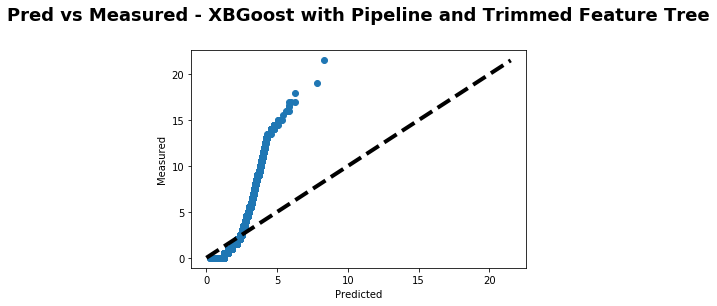

In [254]:
fig, ax = plt.subplots()
ax.set_title('Pred vs Measured - XBGoost with Pipeline and Trimmed Feature Tree', fontsize=18, fontweight='bold',pad=30)
ax.scatter( gsxgb_pred,y_test)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_ylabel('Measured')
ax.set_xlabel('Predicted')
plt.show()


In [249]:
gsxgb_pred.sort()
gsxgb_pred

array([0.24410886, 0.26387244, 0.28772324, ..., 6.249835  , 7.8072333 ,
       8.28212   ], dtype=float32)

In [247]:
y_test.sort()

In [256]:
exportpred_pred = gs_xgb.predict(newplayerbg.values)
exportpred_pred


array([2.5738626, 2.3738518, 2.5482674, ..., 2.3280702, 1.7057385,
       1.7379073], dtype=float32)

In [ ]:
newplayerco = np.append(newplayerbg,exportpred_pred)
newplayerco
#newplayerco.to_csv("trial_one.csv")
exportpred_pred

df = pd.DataFrame({'Actual': target_value.flatten(), 'Predicted': exportpred_pred.flatten()})
df[1:20]

In [293]:
result = pd.concat([newplayerbg.reset_index(), df], axis=1)

In [294]:
result

,player,game_id,game_order,firstname,lastname,FF_signal,toi_signal,onGF_avg_lf,hat_trick_avg_lf,hat_trick_avg_ltwen,skater_pptoi_percentage_avg_lf,onGF_avg_ltwen,iHF_avg_lf,iHF_avg_ltwen,onGF_pp_avg_lf,onFA_state_avg_lf,skater_pptoi_percentage_avg_ltwen,ixG_avg_lf,onxGF_avg_lf,G_avg_lf,Points_avg_lf,onGF_pp_avg_ltwen,OZS_comp_avg_lf,G_avg_ltwen,onxGF_avg_ltwen,ixG_avg_ltwen,Actual,Predicted
0,JAKE.GARDINER,2017020948,81,JAKE,GARDINER,0.0,0.0,0.8,0.0,0.0,6.330975e-01,1.05,1.2,0.75,0.0,14.0,0.555010,0.008397,1.020746,0.0,0.0,0.10,9.8,0.00,1.431455,0.008196,1.5,2.573863
1,SCOTT.HARTNELL,2010020556,495,SCOTT,HARTNELL,0.0,0.0,0.8,0.0,0.0,5.133432e-01,0.65,2.2,2.05,0.2,8.4,0.447993,0.122450,0.510989,0.2,0.2,0.05,5.4,0.05,1.150515,0.030612,4.0,2.373852
2,ERIC.STAAL,2016020538,221,ERIC,STAAL,0.0,1.0,0.4,0.0,0.0,7.670008e-01,0.50,0.6,0.55,0.4,11.0,0.531588,0.012323,1.422895,0.0,0.4,0.20,8.2,0.00,1.334353,0.021083,2.5,2.548267
3,DALE.WEISE,2013020518,363,DALE,WEISE,1.0,0.0,0.0,0.0,0.0,4.461099e-02,0.25,1.6,2.15,0.2,8.0,0.024371,0.137752,0.335826,0.2,0.2,0.05,2.2,0.05,0.758426,0.034438,0.0,1.488498
4,KYLE.CLIFFORD,2011030323,424,KYLE,CLIFFORD,0.0,0.0,0.2,0.0,0.0,2.833333e-02,0.25,1.2,1.75,0.0,2.6,0.041993,0.000000,0.625827,0.0,0.0,0.00,3.0,0.00,0.578281,0.000000,0.0,0.897988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374478,JAMES.WRIGHT,2013020538,23,JAMES,WRIGHT,1.0,1.0,0.2,0.0,0.0,3.469447e-19,0.35,2.4,1.35,0.0,3.2,0.001165,0.000000,0.166794,0.0,0.0,0.00,1.6,0.00,0.380382,0.000000,1.0,0.697677
374479,KYLE.BRODZIAK,2012030155,366,KYLE,BRODZIAK,1.0,1.0,0.2,0.0,0.0,7.407449e-01,0.45,2.2,1.90,0.2,7.0,0.291710,0.000000,1.217651,0.0,0.0,0.05,7.8,0.00,1.036974,0.006580,2.0,1.931617
374480,BLAKE.WHEELER,2012020263,541,BLAKE,WHEELER,1.0,0.0,0.4,0.0,0.0,4.166457e-01,0.70,1.2,1.30,0.0,12.6,0.473074,0.038307,0.780966,0.0,0.0,0.15,6.4,0.00,1.035272,0.016984,4.5,2.328070
374481,ROBYN.REGEHR,2010020730,259,ROBYN,REGEHR,1.0,1.0,1.2,0.0,0.0,8.609173e-03,0.75,2.6,1.75,0.0,13.2,0.066750,0.000000,2.558108,0.0,0.0,0.00,6.4,0.00,1.452776,0.000807,1.5,1.705739


In [ ]:
export = pd.merge(result, base_data_2["game_date"], left_on=['player','game_id', 'game_order'],right_on=['player','game_id','game_order'],how='outer',suffixes=('','_model'))

export.dropna(inplace=True)

In [540]:
export

,level_0,Predicted,lastname,firstname,index,player,game_id,game_order,FF_signal,toi_signal,onGF_avg_lf,hat_trick_avg_lf,hat_trick_avg_ltwen,skater_pptoi_percentage_avg_lf,onGF_avg_ltwen,iHF_avg_lf,iHF_avg_ltwen,onGF_pp_avg_lf,onFA_state_avg_lf,skater_pptoi_percentage_avg_ltwen,ixG_avg_lf,onxGF_avg_lf,G_avg_lf,Points_avg_lf,onGF_pp_avg_ltwen,OZS_comp_avg_lf,G_avg_ltwen,onxGF_avg_ltwen,ixG_avg_ltwen,Actual
game_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-02-24,0,2.573863,GARDINER,JAKE,0,JAKE.GARDINER,2017020948,81,0.0,0.0,0.8,0.0,0.0,6.330975e-01,1.05,1.2,0.75,0.0,14.0,0.555010,0.008397,1.020746,0.0,0.0,0.10,9.8,0.00,1.431455,0.008196,1.5
2010-12-30,1,2.373852,HARTNELL,SCOTT,1,SCOTT.HARTNELL,2010020556,495,0.0,0.0,0.8,0.0,0.0,5.133432e-01,0.65,2.2,2.05,0.2,8.4,0.447993,0.122450,0.510989,0.2,0.2,0.05,5.4,0.05,1.150515,0.030612,4.0
2016-12-29,2,2.548267,STAAL,ERIC,2,ERIC.STAAL,2016020538,221,0.0,1.0,0.4,0.0,0.0,7.670008e-01,0.50,0.6,0.55,0.4,11.0,0.531588,0.012323,1.422895,0.0,0.4,0.20,8.2,0.00,1.334353,0.021083,2.5
2013-12-17,3,1.488498,WEISE,DALE,3,DALE.WEISE,2013020518,363,1.0,0.0,0.0,0.0,0.0,4.461099e-02,0.25,1.6,2.15,0.2,8.0,0.024371,0.137752,0.335826,0.2,0.2,0.05,2.2,0.05,0.758426,0.034438,0.0
2012-05-17,4,0.897988,CLIFFORD,KYLE,4,KYLE.CLIFFORD,2011030323,424,0.0,0.0,0.2,0.0,0.0,2.833333e-02,0.25,1.2,1.75,0.0,2.6,0.041993,0.000000,0.625827,0.0,0.0,0.00,3.0,0.00,0.578281,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-20,374478,0.697677,WRIGHT,JAMES,374478,JAMES.WRIGHT,2013020538,23,1.0,1.0,0.2,0.0,0.0,3.469447e-19,0.35,2.4,1.35,0.0,3.2,0.001165,0.000000,0.166794,0.0,0.0,0.00,1.6,0.00,0.380382,0.000000,1.0
2013-05-09,374479,1.931617,BRODZIAK,KYLE,374479,KYLE.BRODZIAK,2012030155,366,1.0,1.0,0.2,0.0,0.0,7.407449e-01,0.45,2.2,1.90,0.2,7.0,0.291710,0.000000,1.217651,0.0,0.0,0.05,7.8,0.00,1.036974,0.006580,2.0
2013-02-24,374480,2.328070,WHEELER,BLAKE,374480,BLAKE.WHEELER,2012020263,541,1.0,0.0,0.4,0.0,0.0,4.166457e-01,0.70,1.2,1.30,0.0,12.6,0.473074,0.038307,0.780966,0.0,0.0,0.15,6.4,0.00,1.035272,0.016984,4.5


In [332]:
dates

['2016-02-23', '2011-10-25', '2011-03-28', '2016-01-09', '2016-11-05']

In [311]:
import random
random.seed(123)
dates = random.choices(base_data_2.game_date, k=5)

In [337]:
final_export = export[export.index.isin(dates)]

In [338]:
final_export.to_csv('first_test_export.csv')

In [378]:
# Set grid search params
#param_range = [1, 2, 3, 4, 5, 6, 7, 8]
md_range = [1,2,5,10]
param_range_fl = [1.0, 0.5, 0.1]
param_range_treesd = [ None,3,  5]
param_range_treesd = [ 1,3,  5]
param_range_treesf = [None, 10, 20]
param_range_treesne = [500, 600, 700] 
e_stop = [10]
tol = [0.01]


grid_params_sgd = [{'clf__max_iter':param_range_treesne,'clf__tol':tol,'clf__n_iter_no_change':e_stop,'clf__warm_start':[True]}]

grid_params_rf = [{"clf__max_features": param_range_treesf,'clf__max_depth': param_range_treesd, 'clf__n_estimators': param_range_treeml, "clf__min_impurity_decrease":e_stop,'clf__warm_start':[True],'clf__criterion': ['mse']}]

grid_params_xgb = [{"clf__max_features": param_range_treesf,'clf__max_depth': param_range_treesd,  'clf__n_estimators':param_range_treesne, "clf__early_stopping_rounds":e_stop,'clf__warm_start':[True],"clf__scoring":['rmse']}]

# Construct grid searches
jobs = -1
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

gs_sgd = GridSearchCV(estimator=pipe_sgd,param_grid=grid_params_sgd, cv=5,n_jobs=jobs, verbose = 10)

gs_rf = GridSearchCV(estimator=pipe_rf,param_grid=grid_params_rf,cv=5,n_jobs=jobs,verbose = 10)


gs_xgb = GridSearchCV(estimator=pipe_xgb,param_grid=grid_params_xgb,cv=3,n_jobs=jobs,verbose = 10)

In [364]:
## here we'll start with the sgd
import time
sgd_start = time.gmtime()
gs_sgd.fit(X_train, y_train)
sgd_end = time.gmtime()
print("GridSearchCV for SGD took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(sgd_start), len(gs_sgd.cv_results_['params'])))
gs_sgd.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    3.5s remaining:   22.7s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    3.5s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    3.6s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    3.6s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    5.1s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    5.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.2s finished


GridSearchCV for SGD took 6.00 seconds for 3 candidate parameter settings.


{'clf__max_iter': 600,
 'clf__n_iter_no_change': 10,
 'clf__tol': 0.01,
 'clf__warm_start': True}

In [365]:
y_pred = gs_sgd.predict(X_test)
print('R2:', r2_score(y_test, y_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

R2: -0.11488851266094668
Mean Absolute Error: 1.558763600967755
Mean Squared Error: 4.328919842369995
Root Mean Squared Error: 2.080605643164988


In [375]:
gs_rf_start = time.gmtime()
gs_rf.fit(X_train, y_train)
gs_rf_end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(gs_rf_start), len(gs_rf.cv_results_['params'])))
gs_rf.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 13.8min finished


GridSearchCV took 882.00 seconds for 27 candidate parameter settings.


{'clf__criterion': 'mse',
 'clf__max_depth': 1,
 'clf__max_features': None,
 'clf__min_impurity_decrease': 10,
 'clf__n_estimators': 200,
 'clf__warm_start': True}

In [376]:
y_pred = gs_rf.predict(X_test)
print('R2:', r2_score(y_test, y_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

R2: -4.947840937852277e-06
Mean Absolute Error: 1.477324785302934
Mean Squared Error: 3.8828467707903456
Root Mean Squared Error: 1.970494042312827


In [379]:
## I reduced the folds here seeing the earlier errors, and wanting to reduce time
import time
xgb_start = time.gmtime()
gs_xgb.fit(X_train, y_train)
xgb_end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(xgb_start), len(gs_xgb.cv_results_['params'])))
gs_xgb.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done  75 out of  81 | elapsed: 57.2min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 61.8min finished


[12:00:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
GridSearchCV took 3895.00 seconds for 27 candidate parameter settings.


{'clf__early_stopping_rounds': 10,
 'clf__max_depth': 3,
 'clf__max_features': None,
 'clf__n_estimators': 500,
 'clf__scoring': 'rmse',
 'clf__warm_start': True}

In [380]:
y_pred = gs_xgb.predict(X_test)
print('R2:', r2_score(y_test, y_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

R2: -0.11874745570046463
Mean Absolute Error: 1.5639292373281375
Mean Squared Error: 4.343903452753131
Root Mean Squared Error: 2.0842033136796254


Given this relative lack of success thus far, the next step was splitting the target into positional groups and seeing if that would yield a different result, due to the time metrics meaning different things for each set of players.

In [428]:
playerbg_sm3 = pd.merge(playerbg_sm2,pd.DataFrame(target_value),left_index=True, right_index=True)
dmen =  playerbg_sm3[playerbg_sm3.position_avg_D.isin(["1"])]
forwards = playerbg_sm3[playerbg_sm3.position_avg_D.isin(["0"])]
print(dmen.shape)
print(forwards.shape)

(126306, 92)
(248177, 92)


In [56]:
dmen

NameError: name 'dmen' is not defined

In [ ]:
dmen_target =  dmen['dk_points_x'].values
dmen_features = dmen[vif_list['features'].tolist()].values

In [438]:
forwards_target =  forwards['dk_points_x'].values
forwards_features = forwards[vif_list['features'].tolist()].values

In [436]:
## split the data
XD_train, XD_test, yD_train, yD_test = train_test_split(dmen_features, dmen_target, test_size=0.2, random_state=123)

print( XD_train.shape, yD_train.shape)
print (XD_test.shape, yD_test.shape)

(101044, 21) (101044,)
(25262, 21) (25262,)


In [439]:
## split the data
XF_train, XF_test, yF_train, yF_test = train_test_split(forwards_features, forwards_target, test_size=0.2, random_state=123)

print( XF_train.shape, yF_train.shape)
print (XF_test.shape, yF_test.shape)

(198541, 21) (198541,)
(49636, 21) (49636,)


In [440]:
## Start with dmen and just xgb since it's worked best
import time
dxgb_start = time.gmtime()
gs_xgb.fit(XD_train, yD_train)
dxgb_end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(dxgb_start), len(gs_xgb.cv_results_['params'])))
gs_xgb.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  75 out of  81 | elapsed: 16.0min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 17.3min finished


[16:26:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
GridSearchCV took 1068.00 seconds for 27 candidate parameter settings.


{'clf__early_stopping_rounds': 10,
 'clf__max_depth': 1,
 'clf__max_features': None,
 'clf__n_estimators': 500,
 'clf__scoring': 'rmse',
 'clf__warm_start': True}

In [441]:
yD_pred = gs_xgb.predict(XD_test)
print('R2:', r2_score(yD_test, yD_pred)) 
print('Mean Absolute Error:', mean_absolute_error(yD_test, yD_pred))  
print('Mean Squared Error:', mean_squared_error(yD_test, yD_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(yD_test, yD_pred))) 

R2: 0.09307947863819022
Mean Absolute Error: 1.1023029517758423
Mean Squared Error: 2.2131306342056245
Root Mean Squared Error: 1.4876594483300352


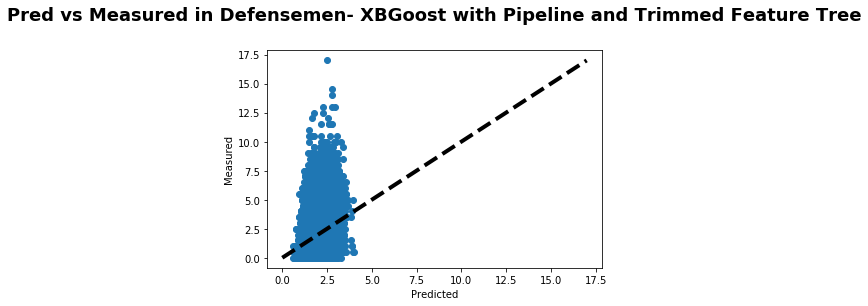

In [442]:
fig, ax = plt.subplots()
ax.set_title('Pred vs Measured in Defensemen- XBGoost with Pipeline and Trimmed Feature Tree', fontsize=18, fontweight='bold',pad=30)
ax.scatter( yD_pred,yD_test)
ax.plot([yD_test.min(), yD_test.max()], [yD_test.min(), yD_test.max()], 'k--', lw=4)
ax.set_ylabel('Measured')
ax.set_xlabel('Predicted')
plt.show()



In [443]:
## Start with dmen and just xgb since it's worked best
import time
fxgb_start = time.gmtime()
gs_xgb.fit(XF_train, yF_train)
Fxgb_end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(Fxgb_start), len(gs_xgb.cv_results_['params'])))
gs_xgb.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done  75 out of  81 | elapsed: 36.8min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 39.7min finished


[17:12:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


NameError: name 'Fxgb_start' is not defined

In [444]:
yF_pred = gs_xgb.predict(XF_test)
print('R2:', r2_score(yF_test, yF_pred)) 
print('Mean Absolute Error:', mean_absolute_error(yF_test, yF_pred))  
print('Mean Squared Error:', mean_squared_error(yF_test, yF_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(yF_test, yF_pred))) 

R2: 0.12361919399578092
Mean Absolute Error: 1.5045963899736123
Mean Squared Error: 4.027195713713756
Root Mean Squared Error: 2.006787411190771


In [448]:
print(yD_pred.mean(),yD_test.mean())
print(yD_pred.std(),yD_test.std())

1.8792475 1.8752474071728287
0.49436116 1.5621362495280329


In [449]:
print(yF_pred.mean(),yF_test.mean())
print(yF_pred.std(),yF_test.std())

2.0843916 2.0850491578692885
0.7543679 2.143655237255263


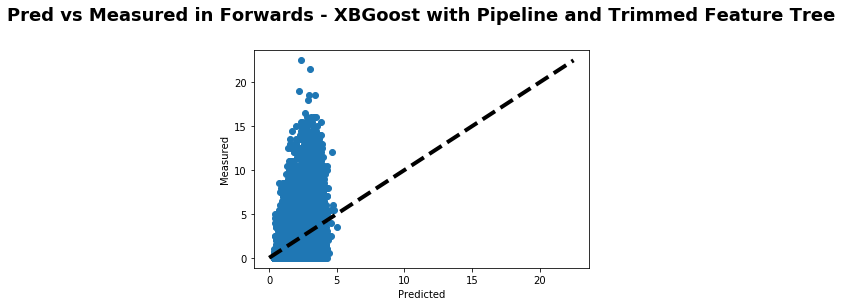

In [447]:
fig, ax = plt.subplots()
ax.set_title('Pred vs Measured in Forwards - XBGoost with Pipeline and Trimmed Feature Tree', fontsize=18, fontweight='bold',pad=30)
ax.scatter( yF_pred,yF_test)
ax.plot([yF_test.min(), yF_test.max()], [yF_test.min(), yF_test.max()], 'k--', lw=4)
ax.set_ylabel('Measured')
ax.set_xlabel('Predicted')
plt.show()



In [ ]:
exportpred_pred2 = gs_xgb.predict(playerbg_sm3[vif_list['features'].tolist()].values)
exportpred_pred2

newplayerco2 = np.append(playerbg_sm3,exportpred_pred2)
newplayerco2

In [460]:
#newplayerco.to_csv("trial_one.csv")
#exportpred_pred2

#df = pd.DataFrame({'Actual': target_value.flatten(), 'Predicted': exportpred_pred2.flatten()})
#df[1:20]
result2 = pd.concat([playerbg_sm3.reset_index(), pd.DataFrame(exportpred_pred2)], axis=1)

In [453]:
result2

,,,,,TOI_comp_avg_lf,G_comp_avg_lf,Points_comp_avg_lf,iSF_comp_avg_lf,iFF_comp_avg_lf,iCF_comp_avg_lf,ixG_comp_avg_lf,iBLK_comp_avg_lf,iHF_avg_lf,OZS_comp_avg_lf,TOI_ev_avg_lf,G_ev_avg_lf,Points_ev_avg_lf,iSF_ev_avg_lf,iFF_ev_avg_lf,iCF_ev_avg_lf,ixG_ev_avg_lf,iBLK_ev_avg_lf,onGF_avg_lf,onFF_avg_lf,onCF_avg_lf,onxGF_avg_lf,onFA_state_avg_lf,TOI_avg_lf,G_avg_lf,Points_avg_lf,iSF_avg_lf,iFF_avg_lf,iCF_avg_lf,ixG_avg_lf,onGF_pp_avg_lf,onSF_pp_avg_lf,onFF_pp_avg_lf,onCF_pp_avg_lf,onxGF_pp_avg_lf,hat_trick_avg_lf,dk_points_avg_lf,skater_toi_percentage_avg_lf,skater_pptoi_percentage_avg_lf,points_per_60_avg_lf,iFF_per_60_avg_lf,ixG_per_60_avg_lf,TOI_comp_avg_ltwen,G_comp_avg_ltwen,Points_comp_avg_ltwen,iSF_comp_avg_ltwen,iFF_comp_avg_ltwen,iCF_comp_avg_ltwen,ixG_comp_avg_ltwen,iBLK_comp_avg_ltwen,iHF_avg_ltwen,OZS_comp_avg_ltwen,TOI_ev_avg_ltwen,G_ev_avg_ltwen,Points_ev_avg_ltwen,iSF_ev_avg_ltwen,iFF_ev_avg_ltwen,iCF_ev_avg_ltwen,ixG_ev_avg_ltwen,iBLK_ev_avg_ltwen,onGF_avg_ltwen,onFF_avg_ltwen,onCF_avg_ltwen,onxGF_avg_ltwen,onFA_state_avg_ltwen,TOI_avg_ltwen,G_avg_ltwen,Points_avg_ltwen,iSF_avg_ltwen,iFF_avg_ltwen,iCF_avg_ltwen,ixG_avg_ltwen,onGF_pp_avg_ltwen,onSF_pp_avg_ltwen,onFF_pp_avg_ltwen,onCF_pp_avg_ltwen,onxGF_pp_avg_ltwen,hat_trick_avg_ltwen,dk_points_avg_ltwen,skater_toi_percentage_avg_ltwen,skater_pptoi_percentage_avg_ltwen,points_per_60_avg_ltwen,iFF_per_60_avg_ltwen,ixG_per_60_avg_ltwen,toi_signal,FF_signal,position_avg_C,position_avg_D,position_avg_L,position_avg_R,dk_points_x,dk_points_y
player,game_id,game_order,firstname,lastname,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
JAKE.GARDINER,2017020948,81,JAKE,GARDINER,19.000000,0.0,0.4,1.2,2.0,3.4,0.203709,1.0,1.2,9.8,16.313333,0.0,0.4,1.2,1.6,2.2,0.189953,0.8,0.8,11.8,14.4,1.020746,14.0,2.093333,0.0,0.0,0.0,0.2,0.4,0.008397,0.0,1.2,2.0,2.2,2.0,0.0,1.9,0.311094,0.633097,1.161099,6.920076,0.613103,22.256667,0.05,0.45,1.65,2.55,3.95,0.280910,1.35,0.75,10.00,19.430833,0.05,0.35,1.35,2.10,3.00,0.264395,1.30,1.05,13.95,18.65,1.431455,15.10,2.103333,0.00,0.05,0.10,0.20,0.40,0.008196,0.10,1.15,1.65,2.15,1.65,0.0,2.450,0.366408,0.555010,1.260214,7.004662,0.759096,0.0,0.0,0,1,0,0,1.5,1.5
SCOTT.HARTNELL,2010020556,495,SCOTT,HARTNELL,15.403333,0.2,0.2,2.8,3.6,4.2,0.482322,0.2,2.2,5.4,12.610000,0.0,0.0,2.2,2.8,3.4,0.359873,0.2,0.8,13.2,17.0,0.510989,8.4,2.760000,0.2,0.2,0.6,0.8,0.8,0.122450,0.2,1.4,2.6,3.0,2.6,0.0,2.1,0.256722,0.513343,0.720721,13.449233,1.926652,16.679167,0.15,0.40,2.80,3.45,4.10,0.371904,0.25,2.05,7.50,13.415833,0.10,0.30,2.45,2.95,3.50,0.312995,0.25,0.65,11.65,15.30,1.150515,9.55,3.119167,0.05,0.05,0.15,0.20,0.25,0.030612,0.05,1.50,2.35,3.05,2.35,0.0,2.475,0.272263,0.447993,1.472518,12.572599,1.393385,0.0,0.0,0,0,1,0,4.0,4.0
ERIC.STAAL,2016020538,221,ERIC,STAAL,19.970000,0.4,1.0,1.6,2.8,3.6,0.323938,0.8,0.6,8.2,14.960000,0.0,0.2,1.0,1.6,2.2,0.033124,0.6,0.4,10.8,16.8,1.422895,11.0,2.813333,0.0,0.4,0.0,0.2,0.4,0.012323,0.4,1.6,2.4,3.2,2.4,0.0,3.8,0.329951,0.767001,3.002751,8.633703,0.986555,19.288333,0.30,0.60,2.50,3.50,4.55,0.379586,0.60,0.55,7.20,14.935000,0.15,0.20,1.85,2.60,3.30,0.218009,0.40,0.50,12.50,17.40,1.334353,9.55,2.375833,0.00,0.15,0.20,0.25,0.40,0.021083,0.20,1.45,1.90,2.75,1.90,0.0,3.100,0.315727,0.531588,1.950794,11.284619,1.239174,1.0,0.0,1,0,0,0,2.5,2.5
DALE.WEISE,2013020518,363,DALE,WEISE,9.166667,0.2,0.2,2.0,2.4,2.6,0.348552,0.4,1.6,2.2,9.103333,0.0,0.0,1.6,2.0,2.2,0.210800,0.4,0.0,5.2,7.0,0.335826,8.0,0.063333,0.2,0.2,0.4,0.4,0.4,0.137752,0.2,0.6,0.6,0.6,0.6,0.0,1.8,0.150368,0.044611,1.112828,16.651576,1.910060,9.105833,0.10,0.15,1.00,1.30,1.50,0.158850,0.30,2.15,2.25,9.024167,0.05,0.10,0.90,1.20,1.40,0.124412,0.30,0.25,5.60,7.70,0.758426,6.20,0.070000,0.05,0.05,0.10,0.10,0.10,0.034438,0.05,0.20,0.20,0.20,0.20,0.0,1.050,0.149836,0.024371,0.810213,8.332962,1.028521,0.0,1.0,0,0,0,1,0.0,0.0
KYLE.CLIFFORD,2011030323,424,KYLE,CLIFFORD,6.866667,0.0,0.0,1.4,1.6,1.6,0.069319,0.0,1.2,3.0,6.576667,0.0,0.

In [462]:
#base_data_2.set_index(["player",'game_id',"game_order", "firstname", "lastname"], inplace=True) 

export2 = pd.merge(result2, base_data_2["game_date"], left_on=['player','game_id', 'game_order'],right_on=['player','game_id','game_order'],how='outer',suffixes=('','_model'))



In [464]:
export2.set_index('game_date', inplace=True)

In [465]:
final_export2 = export2[export2.index.isin(dates)]

In [468]:
final_export2.dropna(inplace=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [469]:
final_export2.to_csv("second_test_export.csv")

This did slightly better, but not much, finding a few more winners lower down the chain. but still for the two main days we compared only one winner out of five contests.

In [27]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [28]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [29]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              dk_points   No. Observations:               299586
Model:                            GLM   Df Residuals:                   299366
Model Family:                 Poisson   Df Model:                          219
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.4397e+05
Date:                Thu, 26 Sep 2019   Deviance:                   4.3344e+05
Time:                        10:21:47   Pearson chi2:                 4.73e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0141      0.006     -2.201      0.0

In [475]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

           mean   mean_se  mean_ci_lower  mean_ci_upper
0      1.564578  0.006181       1.552510       1.576739
1      3.507340  0.017620       3.472975       3.542045
2      1.815610  0.010402       1.795337       1.836112
3      1.424159  0.005951       1.412543       1.435870
4      1.767540  0.006962       1.753948       1.781237
...         ...       ...            ...            ...
74892  1.674345  0.004770       1.665022       1.683721
74893  1.596910  0.005936       1.585317       1.608588
74894  1.985298  0.008612       1.968490       2.002248
74895  1.235357  0.003676       1.228173       1.242583
74896  1.425424  0.006937       1.411892       1.439085

[74897 rows x 4 columns]


In [476]:
PX_train, PX_test, Py_train, Py_test = train_test_split(newplayerbg, base_data['dk_points'], test_size=0.2, random_state=123)



In [477]:
PX_train.head()

,,,,,FF_signal,toi_signal,onGF_avg_lf,hat_trick_avg_lf,hat_trick_avg_ltwen,skater_pptoi_percentage_avg_lf,onGF_avg_ltwen,iHF_avg_lf,iHF_avg_ltwen,onGF_pp_avg_lf,onFA_state_avg_lf,skater_pptoi_percentage_avg_ltwen,ixG_avg_lf,onxGF_avg_lf,G_avg_lf,Points_avg_lf,onGF_pp_avg_ltwen,OZS_comp_avg_lf,G_avg_ltwen,onxGF_avg_ltwen,ixG_avg_ltwen
player,game_id,game_order,firstname,lastname,,,,,,,,,,,,,,,,,,,,,
COLBY.ARMSTRONG,2008020804,205,COLBY,ARMSTRONG,1.0,1.0,0.4,0.0,0.0,0.406364,0.55,1.2,1.25,0.2,6.8,0.307424,0.000000,0.000000,0.0,0.0,0.05,3.6,0.00,0.000000,0.000000
JANNIK.HANSEN,2013020350,245,JANNIK,HANSEN,0.0,0.0,0.2,0.0,0.0,0.125973,0.65,0.6,1.75,0.0,8.8,0.212262,0.000000,0.517644,0.0,0.0,0.10,6.2,0.05,1.106089,0.006317
MARIAN.HOSSA,2016021124,6,MARIAN,HOSSA,0.0,1.0,0.6,0.0,0.0,0.304312,0.35,0.4,0.40,0.4,9.4,0.313459,0.044068,0.961220,0.2,0.4,0.10,4.2,0.05,0.844478,0.021291
VILLE.PELTONEN,2008020865,24,VILLE,PELTONEN,1.0,1.0,0.2,0.0,0.0,0.061445,0.25,0.6,0.95,0.0,11.6,0.086651,0.000000,0.000000,0.0,0.0,0.00,2.8,0.00,0.000000,0.000000
DAVID.SCHLEMKO,2017021232,20,DAVID,SCHLEMKO,0.0,1.0,0.4,0.0,0.0,0.124828,0.60,1.2,0.90,0.0,9.8,0.145513,0.000000,1.399146,0.0,0.0,0.05,4.4,0.00,1.099845,0.004029


In [480]:
Py_train.head()

player           game_id     game_order  firstname  lastname 
COLBY.ARMSTRONG  2008020804  205         COLBY      ARMSTRONG    1.5
JANNIK.HANSEN    2013020350  245         JANNIK     HANSEN       1.0
MARIAN.HOSSA     2016021124  6           MARIAN     HOSSA        1.5
VILLE.PELTONEN   2008020865  24          VILLE      PELTONEN     1.5
DAVID.SCHLEMKO   2017021232  20          DAVID      SCHLEMKO     3.0
Name: dk_points, dtype: float64

In [481]:
poisson_training_results = sm.GLM(Py_train, PX_train, family=sm.families.Poisson()).fit()


In [482]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              dk_points   No. Observations:               299586
Model:                            GLM   Df Residuals:                   299565
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.5495e+05
Date:                Tue, 24 Sep 2019   Deviance:                   4.5541e+05
Time:                        21:55:57   Pearson chi2:                 5.01e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
FF_sig

In [483]:
poisson_predictions = poisson_training_results.get_prediction(PX_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

                                                                     mean  \
player               game_id    game_order firstname   lastname             
JON.SIM              2009021200 37         JON         SIM       1.564578   
KEITH.YANDLE         2010021063 515        KEITH       YANDLE    3.507340   
ALEXEI.EMELIN        2016020895 77         ALEXEI      EMELIN    1.815610   
NIKOLAY.KULEMIN      2015020050 174        NIKOLAY     KULEMIN   1.424159   
WILLIE.MITCHELL      2011020547 223        WILLIE      MITCHELL  1.767540   
...                                                                   ...   
JORDAN.GREENWAY      2018020833 29         JORDAN      GREENWAY  1.674345   
JAMIE.OLEKSIAK       2016020819 162        JAMIE       OLEKSIAK  1.596910   
PIERRE-MARC.BOUCHARD 2011020242 96         PIERRE-MARC BOUCHARD  1.985298   
DANIEL.PAILLE        2013020262 125        DANIEL      PAILLE    1.235357   
TEDDY.BLUEGER        2018021198 6          TEDDY       BLUEGER   1.425424   

In [490]:
poisson_predictions = poisson_training_results.predict(PX_test)

In [491]:
poisson_predictions

player                game_id     game_order  firstname    lastname
JON.SIM               2009021200  37          JON          SIM         1.564578
KEITH.YANDLE          2010021063  515         KEITH        YANDLE      3.507340
ALEXEI.EMELIN         2016020895  77          ALEXEI       EMELIN      1.815610
NIKOLAY.KULEMIN       2015020050  174         NIKOLAY      KULEMIN     1.424159
WILLIE.MITCHELL       2011020547  223         WILLIE       MITCHELL    1.767540
                                                                         ...   
JORDAN.GREENWAY       2018020833  29          JORDAN       GREENWAY    1.674345
JAMIE.OLEKSIAK        2016020819  162         JAMIE        OLEKSIAK    1.596910
PIERRE-MARC.BOUCHARD  2011020242  96          PIERRE-MARC  BOUCHARD    1.985298
DANIEL.PAILLE         2013020262  125         DANIEL       PAILLE      1.235357
TEDDY.BLUEGER         2018021198  6           TEDDY        BLUEGER     1.425424
Length: 74897, dtype: float64

In [492]:
poisson_predictions.mean()

2.0098977782687637

In [493]:
poisson_predictions.std()

0.6408630292441

In [495]:
global_poisson = poisson_training_results.predict(newplayerbg)

In [527]:
global_poisson = pd.DataFrame(global_poisson)
global_poisson.columns = ['poisson_pred']
global_poisson

,,,,,poisson_pred
player,game_id,game_order,firstname,lastname,
JAKE.GARDINER,2017020948,81,JAKE,GARDINER,2.793379
SCOTT.HARTNELL,2010020556,495,SCOTT,HARTNELL,1.964149
ERIC.STAAL,2016020538,221,ERIC,STAAL,2.428747
DALE.WEISE,2013020518,363,DALE,WEISE,1.463345
KYLE.CLIFFORD,2011030323,424,KYLE,CLIFFORD,1.215607
...,...,...,...,...,...
JAMES.WRIGHT,2013020538,23,JAMES,WRIGHT,1.257759
KYLE.BRODZIAK,2012030155,366,KYLE,BRODZIAK,1.899413
BLAKE.WHEELER,2012020263,541,BLAKE,WHEELER,2.272534


In [555]:
poisson_export = export.reset_index().merge(global_poisson, how="left",left_on=['player','game_id', 'game_order'], right_on=['player','game_id', 'game_order']).set_index('index')

In [560]:
cols = ['game_date', "lastname","firstname",'poisson_pred']

poisson_export = poisson_export[cols]
poisson_export.set_index("game_date", inplace=True)

In [562]:
finalpoisson_export = poisson_export[poisson_export.index.isin(dates)]

In [564]:
finalpoisson_export.to_csv('first_poi_export.csv')

While there was significant improvement across the board it was enough to make 1/5 line-ups cash instead of 0/5, not nearly enough in a game where you need ~3/5 to cash to break even. Spliting the defensemen and the forwards was again attempted.

In [565]:
dmen_targetp =  dmen['dk_points_x']
dmen_featuresp = dmen[vif_list['features'].tolist()]
forwards_targetp =  forwards['dk_points_x']
forwards_featuresp = forwards[vif_list['features'].tolist()]
## split the data
XD_train, XD_test, yD_train, yD_test = train_test_split(dmen_featuresp, dmen_targetp, test_size=0.2, random_state=123)

print( XD_train.shape, yD_train.shape)
print (XD_test.shape, yD_test.shape)
## split the data
XF_train, XF_test, yF_train, yF_test = train_test_split(forwards_featuresp, forwards_targetp, test_size=0.2, random_state=123)

print( XF_train.shape, yF_train.shape)
print (XF_test.shape, yF_test.shape)

(101044, 21) (101044,)
(25262, 21) (25262,)
(198541, 21) (198541,)
(49636, 21) (49636,)


In [567]:
poisson_training_results_dmen = sm.GLM(yD_train, XD_train, family=sm.families.Poisson()).fit()
print(poisson_training_results_dmen.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            dk_points_x   No. Observations:               101044
Model:                            GLM   Df Residuals:                   101023
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6847e+05
Date:                Tue, 24 Sep 2019   Deviance:                   1.1107e+05
Time:                        23:36:30   Pearson chi2:                 1.16e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
FF_sig

In [570]:
poisson_predictions = poisson_training_results_dmen.get_prediction(XD_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

                                                                 mean  \
player           game_id    game_order firstname lastname               
SETH.JONES       2016020472 182        SETH      JONES       1.831380   
NICK.SCHULTZ     2008020503 591        NICK      SCHULTZ     1.284599   
DUSTIN.BYFUGLIEN 2010021026 558        DUSTIN    BYFUGLIEN   2.800313   
MICHAEL.STONE    2018020124 5          MICHAEL   STONE       1.884680   
JON.MERRILL      2013021221 266        JON       MERRILL     1.835197   
...                                                               ...   
BRAYDON.COBURN   2010020817 649        BRAYDON   COBURN      1.794777   
ZBYNEK.MICHALEK  2014020429 103        ZBYNEK    MICHALEK    1.476225   
NICK.LEDDY       2017020368 147        NICK      LEDDY       3.469539   
JIM.VANDERMEER   2011020312 19         JIM       VANDERMEER  1.611367   
CONNOR.CARRICK   2017020572 60         CONNOR    CARRICK     1.759047   

                                                  

In [575]:
dmen_ppred = poisson_training_results_dmen.predict(XD_test)
dmen_ppred = pd.DataFrame(dmen_ppred)
dmen_ppred.columns = ['poisson_pred']
dmen_ppred

In [601]:
print(dmen_ppred.shape)
print(XD_test.shape)

(25262, 1)
(25262, 21)


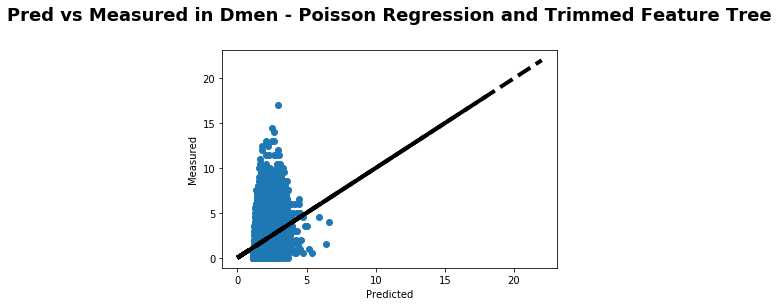

In [606]:
fig, ax = plt.subplots()
ax.set_title('Pred vs Measured in Dmen - Poisson Regression and Trimmed Feature Tree', fontsize=18, fontweight='bold',pad=30)
ax.scatter( dmen_ppred["poisson_pred"],yD_test)
ax.plot([XD_test.min(), XD_test.max()], [XD_test.min(), XD_test.max()], 'k--', lw=4)
ax.set_ylabel('Measured')
ax.set_xlabel('Predicted')
plt.show()



In [610]:
print(dmen_ppred['poisson_pred'].mean())
print(dmen_ppred['poisson_pred'].std())

1.8933963943928818
0.4478441447415245


In [608]:
print(yD_pred.mean(),yD_test.mean())
print(yD_pred.std(),yD_test.std())

1.8792475 1.8752474071728287
0.49436116 1.5621671691431807


In [611]:
poisson_training_results_forwards = sm.GLM(yF_train, XF_train, family=sm.families.Poisson()).fit()
print(poisson_training_results_forwards.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:            dk_points_x   No. Observations:               198541
Model:                            GLM   Df Residuals:                   198520
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.8381e+05
Date:                Tue, 24 Sep 2019   Deviance:                   3.3903e+05
Time:                        23:50:34   Pearson chi2:                 3.68e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
FF_sig

In [613]:
forwards_ppred = poisson_training_results_forwards.predict(XF_test)
forwards_ppred = pd.DataFrame(forwards_ppred)
forwards_ppred.columns = ['poisson_pred']
forwards_ppred

,,,,,poisson_pred
player,game_id,game_order,firstname,lastname,
MIKE.BROWN,2015020724,16,MIKE,BROWN,1.124870
ANDREW.DESJARDINS,2011021059,332,ANDREW,DESJARDINS,1.378649
ERIC.FEHR,2017030244,75,ERIC,FEHR,1.330292
DAVID.CLARKSON,2011020487,245,DAVID,CLARKSON,2.206616
BRAD.RICHARDSON,2011020052,420,BRAD,RICHARDSON,1.671585
...,...,...,...,...,...
ANTOINE.VERMETTE,2016020485,122,ANTOINE,VERMETTE,2.412764
RENE.BOURQUE,2014020024,153,RENE,BOURQUE,1.879204
MITCH.MARNER,2018020706,38,MITCHELL,MARNER,3.717370


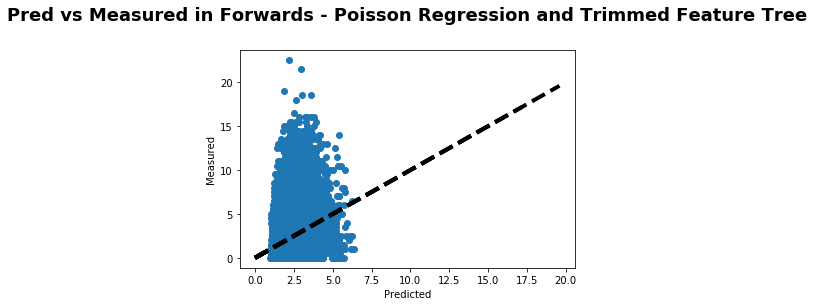

In [614]:
fig, ax = plt.subplots()
ax.set_title('Pred vs Measured in Forwards - Poisson Regression and Trimmed Feature Tree', fontsize=18, fontweight='bold',pad=30)
ax.scatter( forwards_ppred["poisson_pred"],yF_test)
ax.plot([XF_test.min(), XF_test.max()], [XF_test.min(), XF_test.max()], 'k--', lw=4)
ax.set_ylabel('Measured')
ax.set_xlabel('Predicted')
plt.show()



In [615]:
print(forwards_ppred['poisson_pred'].mean())
print(forwards_ppred['poisson_pred'].std())
print(yF_pred.mean(),yF_test.mean())
print(yF_pred.std(),yF_test.std())

2.104888589992822
0.7160593043923504
2.0843916 2.0850491578692885
0.7543679 2.1436768313363195


In [ ]:
poisson_predictions = poisson_training_results.predict(PX_test)

In [622]:
print('mean D-Men: ',dmen_ppred['poisson_pred'].mean())
print('global mean: ',poisson_predictions.mean())
print('mean Forwards: ',forwards_ppred['poisson_pred'].mean())

mean D-Men:  1.8933963943928818
global mean:  2.0098977782687637
mean Forwards:  2.104888589992822


In [623]:
print('st. dv. D-Men: ',dmen_ppred['poisson_pred'].std())
print('global st. dv.: ',poisson_predictions.std())
print('st. dv. Forwards: ',forwards_ppred['poisson_pred'].std())

st. dv. D-Men:  0.4478441447415245
global st. dv.:  0.6408630292441
st. dv. Forwards:  0.7160593043923504


In [618]:
print(poisson_predictions.mean())
print(poisson_predictions.std())

2.0098977782687637
0.6408630292441


Noteable here is that in both cases the standard deviation tightened up from the last split model as well as the standard distribution. Just for fun these were joined back together and exported as well for testing.

In [625]:
forwards_p = poisson_training_results_forwards.predict(forwards_featuresp)
dmen_p = poisson_training_results_forwards.predict(dmen_featuresp)

In [626]:
forwards_p.head()

player             game_id     game_order  firstname  lastname
SCOTT.HARTNELL     2010020556  495         SCOTT      HARTNELL    2.058442
ERIC.STAAL         2016020538  221         ERIC       STAAL       2.691541
DALE.WEISE         2013020518  363         DALE       WEISE       1.476140
KYLE.CLIFFORD      2011030323  424         KYLE       CLIFFORD    1.241674
VALTTERI.FILPPULA  2018020516  49          VALTTERI   FILPPULA    1.680903
dtype: float64

In [627]:
dmen_p.head()

player         game_id     game_order  firstname  lastname
JAKE.GARDINER  2017020948  81          JAKE       GARDINER    3.452897
CHAD.RUHWEDEL  2017020504  49          CHAD       RUHWEDEL    1.783956
ROMAN.JOSI     2016020418  154         ROMAN      JOSI        4.155301
JON.MERRILL    2018020505  47          JON        MERRILL     2.100310
MATT.HUNWICK   2009020035  461         MATT       HUNWICK     2.721462
dtype: float64

In [629]:
joined_tables = forwards_p.append(dmen_p)

In [631]:
segmented_poisson = pd.DataFrame(joined_tables)
segmented_poisson.columns = ['poisson_pred']
print(segmented_poisson.head)
segmented_poisson_export = export.reset_index().merge(segmented_poisson, how="left",left_on=['player','game_id', 'game_order'], right_on=['player','game_id', 'game_order']).set_index('index')
cols = ['game_date', "lastname","firstname",'poisson_pred']

segmented_poisson_export = segmented_poisson_export[cols]
segmented_poisson_export.set_index("game_date", inplace=True)
segmented_poisson_export.to_csv('second_poi_export.csv')

<bound method NDFrame.head of                                                             poisson_pred
player            game_id    game_order firstname lastname              
SCOTT.HARTNELL    2010020556 495        SCOTT     HARTNELL      2.058442
ERIC.STAAL        2016020538 221        ERIC      STAAL         2.691541
DALE.WEISE        2013020518 363        DALE      WEISE         1.476140
KYLE.CLIFFORD     2011030323 424        KYLE      CLIFFORD      1.241674
VALTTERI.FILPPULA 2018020516 49         VALTTERI  FILPPULA      1.680903
...                                                                  ...
JONAS.BRODIN      2015030151 239        JONAS     BRODIN        2.150261
RYAN.ELLIS        2014020027 250        RYAN      ELLIS         3.241430
DUNCAN.KEITH      2015020414 250        DUNCAN    KEITH         4.000346
ROBYN.REGEHR      2010020730 259        ROBYN     REGEHR        2.261240
STEVE.EMINGER     2010020251 141        STEVE     EMINGER       1.813596

[374483 rows x 1 col

In [39]:
X_train, X_test, y_train, y_test = train_test_split(playerbg,base_data['dk_points'], test_size=0.2, random_state=123)
poisson_training_results_restart = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [40]:
print(poisson_training_results_restart.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              dk_points   No. Observations:               299586
Model:                            GLM   Df Residuals:                   299366
Model Family:                 Poisson   Df Model:                          219
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.4397e+05
Date:                Thu, 26 Sep 2019   Deviance:                   4.3344e+05
Time:                        10:30:29   Pearson chi2:                 4.73e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0141      0.006     -2.201      0.0

In [42]:
poisson_restart_preds = poisson_training_results_restart.predict(X_test)

In [43]:
poisson_restart_preds.mean()

2.006726897229264

In [44]:
poisson_restart_preds.std()

0.7519345661132537

In [45]:
#yF_pred = gs_xgb.predict(XF_test)
print('R2:', r2_score(y_test, poisson_restart_preds)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, poisson_restart_preds))  
print('Mean Squared Error:', mean_squared_error(y_test, poisson_restart_preds))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, poisson_restart_preds))) 

R2: 0.1407510526013983
Mean Absolute Error: 1.3451672384561262
Mean Squared Error: 3.3363154931532852
Root Mean Squared Error: 1.826558373869635


This showed noted progress and better error rates, but still almost a standard deviation off in the MAE. In order to further reduce noise a smaller subgroup of both the dmen and the forwards were selected, trimming off players that were more than a standard deviation below the mean in each both forwards and defensive players.

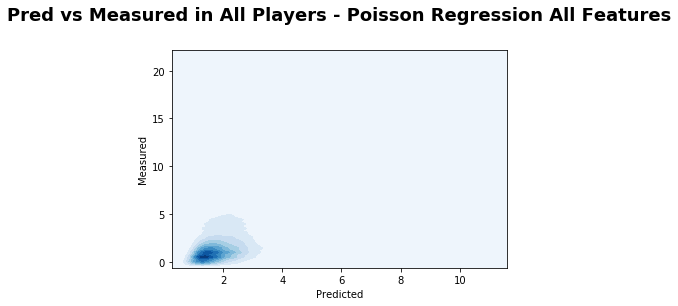

In [212]:
import seaborn as sns
fig, ax = plt.subplots()
ax.set_title('Pred vs Measured in All Players - Poisson Regression All Features', fontsize=18, fontweight='bold',pad=30)
sns.kdeplot( poisson_restart_preds,y_test,cmap="Blues", shade=True)
#ax.plot([X_test.min(), X_test.max()], [X_test.min(), X_test.max()], 'k--', lw=2)
ax.set_ylabel('Measured')
ax.set_xlabel('Predicted')
plt.show()



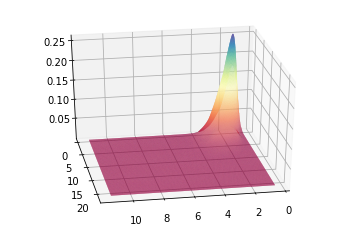

In [214]:
from scipy.stats import kde
from mpl_toolkits.mplot3d import Axes3D
nbins=300

k = kde.gaussian_kde([poisson_restart_preds,y_test])
xi, yi = np.mgrid[ poisson_restart_preds.min():poisson_restart_preds.max():nbins*1j, y_test.min():y_test.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Transform it in a dataframe
data=pd.DataFrame({'x': xi.flatten(), 'y': yi.flatten(), 'z': zi })
 
# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(data.x, data.y, data.z, cmap=plt.cm.Spectral, linewidth=0.2)
# Adapt angle, first number is up/down, second number is right/left
ax.view_init(30, 80)


In [240]:
merged_preds = pd.DataFrame(zip(poisson_restart_preds,y_test))
merged_preds_sam = merged_preds.sample(5000)

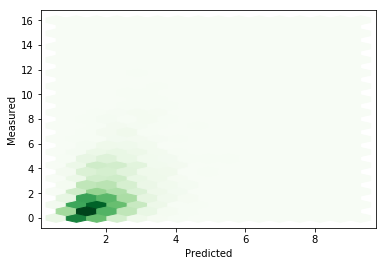

In [247]:
fig, ax = plt.subplots()
ax.hexbin( merged_preds_sam[0],merged_preds_sam[1], gridsize=(15,15), cmap="Greens")
#ax.plot([X_test.min(), X_test.max()], [X_test.min(), X_test.max()], 'k--', lw=2)
ax.set_ylabel('Measured')
ax.set_xlabel('Predicted')
plt.show()

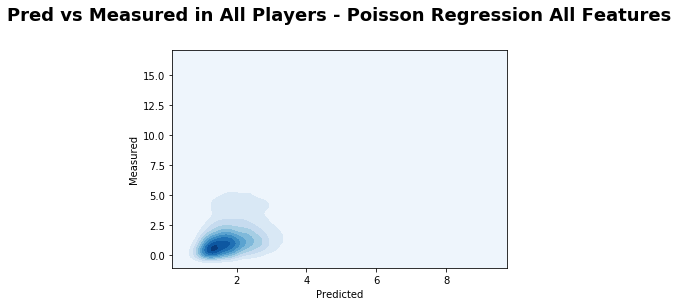

In [242]:
import seaborn as sns
fig, ax = plt.subplots()
ax.set_title('Pred vs Measured in All Players - Poisson Regression All Features', fontsize=18, fontweight='bold',pad=30)
sns.kdeplot( merged_preds_sam[0],merged_preds_sam[1],cmap="Blues", shade=True)
#ax.plot([X_test.min(), X_test.max()], [X_test.min(), X_test.max()], 'k--', lw=2)
ax.set_ylabel('Measured')
ax.set_xlabel('Predicted')
plt.show()

In [55]:
##calculating averages
print('d-men average TOI: ', playerbg[playerbg.position_avg_D.isin(["1"])]["TOI_comp"].mean())
print('d-men std TOI: ', playerbg[playerbg.position_avg_D.isin(["1"])]["TOI_comp"].std())
print('forwards average TOI: ', playerbg[playerbg.position_avg_D.isin(["0"])]["TOI_comp"].mean())
print('forwards std TOI: ', playerbg[playerbg.position_avg_D.isin(["0"])]["TOI_comp"].std())

d-men average TOI:  19.82475337671981
d-men std TOI:  4.608601438691811
forwards average TOI:  15.052496336619901
forwards std TOI:  4.33996731004214


In [147]:
new_cols = [col for col in playerbg.columns if '_avg' in col]

playerbg2 = playerbg[new_cols]
lost_cols = ['toi_signal', 'FF_signal','dk_points']

lost_cols = playerbg[lost_cols]
playerbg2 = playerbg2.merge(lost_cols, left_index=True, right_index=True)

playerbg_dmen = playerbg2[playerbg2.position_avg_D.isin(["1"])]
playerbg_forwards = playerbg2[playerbg2.position_avg_D.isin(["0"])]


In [148]:
playerbg_forwards.shape

(248177, 231)

Players a standard deviation below their catagorical mean were cut to refine the process, meaning below 15.21 minutes for defensive players and below 10.71 for forwards.

In [149]:
hv = playerbg_dmen['TOI_comp_avg_lf']>=15.21
                   
hv_playerbg_dmen = playerbg_dmen[hv]

In [150]:
hv_playerbg_dmen.shape

(110211, 231)

In [151]:
hvf = playerbg_forwards['TOI_comp_avg_lf']>=10.71
                   
hv_playerbg_fwds = playerbg_forwards[hvf]

In [156]:
HFX_train, HFX_test, HFy_train, HFy_test = train_test_split(hv_playerbg_fwds[hv_playerbg_fwds.columns[0:230]], hv_playerbg_fwds['dk_points'], test_size=0.2, random_state=123)

poisson_hvf = sm.GLM(HFy_train, HFX_train, family=sm.families.Poisson()).fit()

In [157]:
print(poisson_hvf.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              dk_points   No. Observations:               169681
Model:                            GLM   Df Residuals:                   169460
Model Family:                 Poisson   Df Model:                          220
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.3666e+05
Date:                Thu, 26 Sep 2019   Deviance:                   2.8620e+05
Time:                        21:44:25   Pearson chi2:                 3.12e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
TOI_co

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [158]:
poisson_hvf_preds = poisson_hvf.predict(HFX_test)

In [159]:
#yF_pred = gs_xgb.predict(XF_test)
print('R2:', r2_score(HFy_test, poisson_hvf_preds)) 
print('Mean Absolute Error:', mean_absolute_error(HFy_test, poisson_hvf_preds))  
print('Mean Squared Error:', mean_squared_error(HFy_test, poisson_hvf_preds))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(HFy_test, poisson_hvf_preds))) 

R2: 0.1104044502880478
Mean Absolute Error: 1.5807642711497225
Mean Squared Error: 4.339167038157224
Root Mean Squared Error: 2.0830667387669615


In [160]:
HDX_train, HDX_test, HDy_train, HDy_test = train_test_split(hv_playerbg_dmen[hv_playerbg_dmen.columns[0:230]], hv_playerbg_dmen['dk_points'], test_size=0.2, random_state=123)

poisson_hvd = sm.GLM(HDy_train, HDX_train, family=sm.families.Poisson()).fit()

In [177]:
print(poisson_hvd.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              dk_points   No. Observations:                88168
Model:                            GLM   Df Residuals:                    87949
Model Family:                 Poisson   Df Model:                          218
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4853e+05
Date:                Thu, 26 Sep 2019   Deviance:                       93890.
Time:                        21:50:50   Pearson chi2:                 9.91e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
TOI_co

In [ ]:
poisson_hvd_preds = poisson_hvd.predict(HDX_test)

In [164]:
print('R2:', r2_score(HDy_test, poisson_hvd_preds)) 
print('Mean Absolute Error:', mean_absolute_error(HDy_test, poisson_hvd_preds))  
print('Mean Squared Error:', mean_squared_error(HDy_test, poisson_hvd_preds))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(HDy_test, poisson_hvd_preds)))

R2: 0.09942463238636434
Mean Absolute Error: 1.1191506175416868
Mean Squared Error: 2.2279537961963998
Root Mean Squared Error: 1.492633175363726


In [165]:
vif = pd.read_csv('vif3.csv')

hv_playerbg_fwds2 = hv_playerbg_fwds[vif['features'].tolist()]

HFX_train, HFX_test, HFy_train, HFy_test = train_test_split(hv_playerbg_fwds2, hv_playerbg_fwds['dk_points'], test_size=0.2, random_state=123)

poisson_hvfv = sm.GLM(HFy_train, HFX_train, family=sm.families.Poisson()).fit()

In [167]:
print(poisson_hvfv.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              dk_points   No. Observations:               169681
Model:                            GLM   Df Residuals:                   169660
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.4154e+05
Date:                Thu, 26 Sep 2019   Deviance:                   2.9596e+05
Time:                        21:45:50   Pearson chi2:                 3.22e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
FF_sig

In [168]:
poisson_hvfv_preds = poisson_hvfv.predict(HFX_test)

In [169]:
print('R2:', r2_score(HFy_test, poisson_hvfv_preds)) 
print('Mean Absolute Error:', mean_absolute_error(HFy_test, poisson_hvfv_preds))  
print('Mean Squared Error:', mean_squared_error(HFy_test, poisson_hvfv_preds))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(HFy_test, poisson_hvfv_preds))) 

R2: 0.08740965954435931
Mean Absolute Error: 1.6042232088214676
Mean Squared Error: 4.451328388420997
Root Mean Squared Error: 2.109817145731117


In [172]:
HDX_train, HDX_test, HDy_train, HDy_test = train_test_split(hv_playerbg_dmen[vif['features'].tolist()], hv_playerbg_dmen['dk_points'], test_size=0.2, random_state=123)

poisson_hvdv = sm.GLM(HDy_train, HDX_train, family=sm.families.Poisson()).fit()

In [174]:
print(poisson_hvdv.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              dk_points   No. Observations:                88168
Model:                            GLM   Df Residuals:                    88147
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5040e+05
Date:                Thu, 26 Sep 2019   Deviance:                       97639.
Time:                        21:49:15   Pearson chi2:                 1.03e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
FF_sig

In [175]:
poisson_hvdv_preds = poisson_hvdv.predict(HDX_test)

In [176]:
print('R2:', r2_score(HDy_test, poisson_hvdv_preds)) 
print('Mean Absolute Error:', mean_absolute_error(HDy_test, poisson_hvdv_preds))  
print('Mean Squared Error:', mean_squared_error(HDy_test, poisson_hvdv_preds))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(HDy_test, poisson_hvdv_preds))) 

R2: 0.07394383707170271
Mean Absolute Error: 1.1396890983360786
Mean Squared Error: 2.290991312758544
Root Mean Squared Error: 1.5136020985577894


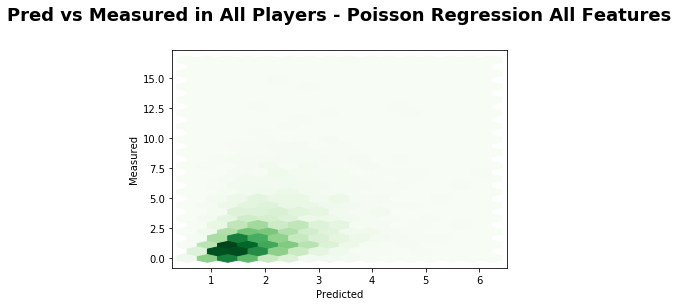

In [246]:
merged_Dpreds = pd.DataFrame(zip(poisson_hvdv_preds,HDy_test))
merged_Dpreds_sam = merged_preds.sample(5000)

fig, ax = plt.subplots()
ax.set_title('Pred vs Measured in All Players - Poisson Regression All Features', fontsize=18, fontweight='bold',pad=30)
ax.hexbin(merged_Dpreds_sam[0],merged_Dpreds_sam[1],gridsize=(15,15), cmap='Greens')
#ax.plot([X_test.min(), X_test.max()], [X_test.min(), X_test.max()], 'k--', lw=2)
ax.set_ylabel('Measured')
ax.set_xlabel('Predicted')
plt.show()



Given that the global model is the most successful as far as variance explained and close on error metrics, as well as having the widest application, that will be our winner in this case.

In [250]:
import pickle
pickle.dumps(poisson_training_results_restart) 

In [253]:
from sklearn.externals import joblib
import pickle
import bz2
# Save to file in the current working directory
jsfile = bz2.BZ2File('capstone_2_final_poisson', 'w')
joblib.dump(poisson_training_results_restart, jsfile)